## PROBLEMA 1

Clases de Modelo Físico:

MorseParameters: Encapsula los parámetros del potencial de Morse y calcula la energía de interacción

MorseParameterDatabase: Gestiona todos los parámetros para diferentes pares de átomos

Atom: Representa un átomo individual con su tipo y posición

CrystalLattice2D: Modela la red cristalina completa, calcula energía total y gestiona la sustitución de átomos

Clases de Optimización:

BruteForceOptimizer: Implementa la búsqueda exhaustiva evaluando todas las configuraciones posibles

SimulatedAnnealingOptimizer: Implementa el algoritmo de recocido simulado con esquema de enfriamiento geométrico

---

In [2]:
import copy
from dataclasses import dataclass
import random
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

MorseParameters encapsula los tres parámetros que definen completamente una interacción de Morse entre dos átomos. Calculate_energy implementa la fórmula del potencial de Morse.

In [2]:
@dataclass
class MorseParameters:
    """Parametros del potencial de Morse para una interacción específica."""
    D0: float  #Energia de enlace
    alpha: float  #Parametro de ancho
    r0: float  #Distancia de equilibrio

    def calculate_energy(self, r: float) -> float:
        """
        Calcula la energía de interacción para una distancia r.
        U(r) = D0 * [exp(-2*alpha*(r-r0)) - 2*exp(-alpha*(r-r0))]
        """
        term1 = np.exp(-2 * self.alpha * (r - self.r0))
        term2 = 2 * np.exp(-self.alpha * (r - self.r0))
        return self.D0 * (term1 - term2)

Esta clase almacena todos los parámetros del potencial de Morse para cada tipo de interacción posible. Usamos un diccionario donde las llaves son tuplas de dos elementos representando el par de átomos que interactúan. Los valores específicos de los parametros vienen de la Tabla del enunciado de la tarea.

In [3]:
class MorseParameterDatabase:
    """Base de datos de parámetros de Morse para diferentes tipos de interacciones."""

    def __init__(self):
        self.parameters = {
            ('Fe', 'Fe'): MorseParameters(D0=0.764, alpha=1.5995, r0=2.7361),
            ('Fe', 'R'): MorseParameters(D0=0.6036, alpha=1.6458, r0=3.188),
            ('Fe', 'Ti'): MorseParameters(D0=0.8162, alpha=1.448, r0=2.914),
            ('R', 'R'): MorseParameters(D0=0.312, alpha=0.945, r0=4.092),
            ('R', 'Ti'): MorseParameters(D0=0.4964, alpha=1.4401, r0=3.4309),
            ('Ti', 'Ti'): MorseParameters(D0=0.6540, alpha=1.2118, r0=3.3476)
        }

    def get_parameters(self, atom1: str, atom2: str) -> MorseParameters:
        """Obtiene los parámetros para un par de átomos."""
        key = tuple(sorted([atom1, atom2]))
        return self.parameters.get(key, self.parameters.get((atom2, atom1)))

Esta clase representa un átomo individual en nuestra red. Cada átomo tiene propiedades esenciales como el tipo, la posicion y si es fijo en la red o no. En 'distance_to' se multiplica por 2.8 pues en algunos materiales, las distancias entre vecinos más cercanos son de aproximadamente ~2,8 Å. Por lo tanto, esto también podría ser la constante de calibración para este tipo de red específico.

In [5]:
class Atom:
    """Representa un átomo en la red cristalina."""

    #?Why is position a tuple of floats and not a tuple of ints?
    def __init__(self, atom_type: str, position: Tuple[float, float], fixed: bool = True):
        self.atom_type = atom_type
        self.position = position
        self.pos_arr = np.array(position, dtype=float)
        self.fixed = fixed

    def distance_to(self, other: 'Atom') -> float:
        """Calcula la distancia euclidiana a otro átomo."""
        return 2.8 * np.linalg.norm(self.pos_arr - other.pos_arr)

`CrystalLattice2D` representa toda la red cristalina completa. Mantiene una lista de todos los átomos en el sistema. Guarda una referencia a la base de datos de Morse para poder calcular energías de interacción cuando sea necesario. El atributo `ti_pos` rastrea qué átomo en la lista es actualmente el átomo de Titanio. Este índice nos permite cambiar rápidamente entre diferentes configuraciones sin tener que recrear toda la red cada vez. '

In [5]:
class CrystalLattice2D:
    """Representa una red cristalina 2D con átomos."""

    def __init__(self, morse_db: MorseParameterDatabase,
                 shape: Tuple[int, int] = (4, 4)):
        self.shape: list = shape
        self.atoms: List[List[Atom]] = [[None for _ in range(shape[1])] for _ in range(shape[0])]
        self.fe_sites: list[Tuple[int, int]] = []
        self.morse_db: MorseParameterDatabase = morse_db
        self.ti_pos: Tuple[int, int] = None # Indice del átomo de Ti si existe

    def add_atom(self, atom: Atom):
        """Añade un átomo a la red."""
        self.atoms[atom.position[0]][atom.position[1]] = atom

    def calculate_total_energy(self) -> float:
        """
        Calcula la energía total del sistema sumando todas las
        interacciones de pares únicos.
        CANTIDAD QUE QUEREMOS MINIMIZAR
        """
        total_energy = 0.0
        n_total_atoms = len(self.atoms) * len(self.atoms[0]) # la red debe ser cuadrada
        n_row_atoms = len(self.atoms[0]) # debe ser = al número de columnas

        # Calcular la sumatoria sum_{i} sum_{j>i} U_{ij}(r_{ij})
        for i in range(n_total_atoms):
            for j in range(i + 1, n_total_atoms):
                atom_i = self.atoms[int(i / n_row_atoms)][i % n_row_atoms]
                atom_j = self.atoms[int(j / n_row_atoms)][j % n_row_atoms]

                distance = atom_i.distance_to(atom_j)
                params = self.morse_db.get_parameters( # obtener alpha, r0 y D0
                    atom_i.atom_type,
                    atom_j.atom_type
                )

                if params: # si son atomos de Fe, R o Ti
                    energy = params.calculate_energy(distance)
                    total_energy += energy

        return total_energy

    def set_ti_position(self, fe_pos: tuple):
        """
        Sustituye un átomo de Fe por Ti en `fe_pos` si:
        - Ambas componentes de `fe_pos` son menores que la dimensión de un lado
        del retículo.
        - En `fe_pos` hay un átomo movible.
        """
        # Restaurar cualquier Ti previo a Fe
        if self.ti_pos is not None:
            self.atoms[self.ti_pos[0]][self.ti_pos[1]].atom_type = 'Fe'

        if fe_pos[0] >= self.shape[0] or fe_pos[1] >= self.shape[1]:
            print(f"Posición ({fe_pos[0]}, {fe_pos[1]}) está fuera del retículo. Máxima posición es: ({self.shape[0], self.shape[1]}).")
            return

        #?Worth checking if the atom type is Ti or Fe if we are checking whether the position has a fixed atom or not, which should be equivalent?

        if self.atoms[fe_pos[0]][fe_pos[1]].fixed:
            print(f"Posición ({fe_pos[0]}, {fe_pos[1]}) es fija.")
            return

        self.atoms[fe_pos[0]][fe_pos[1]].atom_type = 'Ti'
        self.ti_pos = fe_pos

    def get_state(self) -> tuple:
        """Retorna el índice del átomo de Fe que contiene Ti"""
        if self.ti_pos is None:
            return (-1, -1)
        return self.ti_pos
        # fe_atoms_indices = [i for i, atom in enumerate(self.atoms)
        #                    if not atom.fixed]
        # return fe_atoms_indices.index(self.ti_pos) if self.ti_pos in fe_atoms_indices else -1

    def visualize(self, title: str = "Configuración de la Red"):
        """Visualiza la red cristalina"""
        fig, ax = plt.subplots(figsize=(8, 8))

        for row in self.atoms:
            for atom in row:
                x, y = atom.position
                if atom.atom_type == 'R':
                    color = 'red'
                    marker = 's'
                    size = 200
                elif atom.atom_type == 'Fe':
                    color = 'blue'
                    marker = 'o'
                    size = 150
                else:  # Ti
                    color = 'green'
                    marker = '^'
                    size = 200

                ax.scatter(2.8*x, 2.8*y, c=color, marker=marker, s=size,
                        edgecolors='black', linewidths=2, label=atom.atom_type)

        # Remover duplicados en la leyenda
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=12)

        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

Esta clase implementa la búsqueda exhaustiva que necesitamos para ecnontrar la configuración óptima. Recibe una referencia a la red sobre la cual trabajará. Calcula cuántos sitios de Fe hay disponibles para saber cuantas configuraciones diferentes necesitamos evaluar. 'optimize' implementa el algoritmo de fuerza bruta completo con un bucle principal que itera sobre cada posible sitio de Fe. Para cada iteración, colocamos el Ti en esa posición usando set_ti_position, calculamos la energía total de esa configuración, y guardamos el resultado en nuestra lista.  

In [7]:
class BruteForceOptimizer:
    """Optimizador por fuerza bruta para encontrar la configuración óptima."""

    def __init__(self, lattice: CrystalLattice2D):
        self.lattice = lattice
        fe_sites: list = []
        for row in lattice.atoms:
            for atom in row:
                if not atom.fixed:
                    fe_sites.append(atom.position)
        self.lattice.fe_sites = fe_sites

    def optimize(self) -> Tuple[int, float, List[float]]:
        """
        Encuentra la posición óptima evaluando todas las configuraciones posibles.
        """
        energies = []
        min_energy = float('inf')
        best_position = (0, 0)

        for pos in self.lattice.fe_sites:
            self.lattice.set_ti_position(pos)
            energy = self.lattice.calculate_total_energy()
            energies.append(energy)

            print(f"Posición {pos}: Energía = {energy:.6f}")

            if energy < min_energy:
                min_energy = energy
                best_position = pos

        print(f"\nMejor posición encontrada: {best_position}")
        print(f"Energía mínima: {min_energy:.6f}")

        return best_position, min_energy, energies

Esta clase implementa el centro del recocido simulado. Los parámetros del constructor definen el calendario de enfriamiento. La temperatura inicial de diez es alta, lo que significa que al principio aceptaremos muchas transiciones malas. La temperatura final de cero punto cero uno es muy baja, así que al final solo aceptaremos mejoras. El cooling_rate de cero punto noventa y cinco significa que en cada paso multiplicamos la temperatura por este valor, lo cual crea un decrecimiento exponencial. El parámetro iterations_per_temp indica cuántas veces intentamos mover el Ti antes de bajar la temperatura. En 'acceptance_probability' tenemos en cuenta el criterio clave, si la nueva configuración tiene menor energía que la actual, siempre la aceptamos retornando probabilidad uno. Cuando la nueva energía es mayor, todavía podríamos aceptarla con una probabilidad que depende exponencialmente de dos factores: qué tan peor es la nueva configuración (current_energy menos new_energy, que será negativo), y la temperatura actual. 'optimize' ejecuta el algoritmo completo de recocido simulado.

In [8]:
class SimulatedAnnealingOptimizer:
    """
    Implementación del algoritmo de Recocido Simulado para optimización
    de la posición de átomos de Ti.
    """

    def __init__(self, lattice: CrystalLattice2D,
                 initial_temp: float = 10.0,
                 final_temp: float = 0.01,
                 cooling_rate: float = 0.95,
                 iterations_per_temp: int = 100):
        self.lattice = lattice
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate
        self.iterations_per_temp = iterations_per_temp

        # para seguimiento
        self.energy_history = []
        self.temperature_history = []
        self.best_energy_history = []

    def _get_neighbor(self, current_position: int) -> int:
        """Genera una posición vecina eligiendo aleatoriamente otro sitio de Fe."""
        return random.choice(self.lattice.fe_sites)

    def _acceptance_probability(self, current_energy: float, new_energy: float, temperature: float) -> float:
        """
        Calcula la probabilidad de aceptación según el criterio de Metropolis. 
        """
        if new_energy < current_energy:
            return 1.0
        return np.exp((current_energy - new_energy) / temperature)

    def optimize(self, initial_position: int = None) -> Tuple[int, float]:
        """
        Ejecuta el algoritmo de SA.
        """
        if initial_position is None:
            current_position = random.choice(lattice.fe_sites)
        else:
            current_position = initial_position

        self.lattice.set_ti_position(current_position)
        current_energy = self.lattice.calculate_total_energy()

        best_position = current_position
        best_energy = current_energy

        temperature = self.initial_temp
        iteration = 0

        print(f"Temperatura inicial: {temperature:.4f}")
        print(f"Posición inicial: {current_position}, Energía: {current_energy:.6f}\n")

        while temperature > self.final_temp:
            for _ in range(self.iterations_per_temp):
                # Generar vecino
                new_position = self._get_neighbor(current_position)

                # Calcular energía del vecino
                self.lattice.set_ti_position(new_position)
                new_energy = self.lattice.calculate_total_energy()

                # Decidir si aceptar la transición
                acceptance_prob = self._acceptance_probability(
                    current_energy, new_energy, temperature
                )

                if np.random.random() < acceptance_prob:
                    current_position = new_position
                    current_energy = new_energy

                    # Actualizar mejor solución
                    if current_energy < best_energy:
                        best_position = current_position
                        best_energy = current_energy
                else:
                    # Restaurar posición actual
                    self.lattice.set_ti_position(current_position)

                # Registro para análisis
                self.energy_history.append(current_energy)
                self.temperature_history.append(temperature)
                self.best_energy_history.append(best_energy)
                iteration += 1

            # Enfriamiento
            temperature *= self.cooling_rate

            if iteration % 500 == 0:
                print(f"Iteración {iteration}: T={temperature:.4f}, "
                      f"E_actual={current_energy:.6f}, E_mejor={best_energy:.6f}")

        print(f"\nOptimización completada.")
        print(f"Mejor posición: {best_position}")
        print(f"Mejor energía: {best_energy:.6f}")

        # Establecer la mejor configuración
        self.lattice.set_ti_position(best_position)

        return best_position, best_energy

    def plot_convergence(self):
        """Visualiza la convergencia del algoritmo."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        iterations = range(len(self.energy_history))

        # Gráfico de energía
        ax1.plot(iterations, self.energy_history, alpha=0.6,
                 linewidth=2, label='Energía actual')
        ax1.plot(iterations, self.best_energy_history, 'r-',
                linewidth=1, label='Mejor energía')
        ax1.set_xlabel('Iteración')
        ax1.set_ylabel('Energía')
        ax1.set_title('Convergencia de Energía')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Gráfico de temperatura
        ax2.plot(iterations, self.temperature_history, 'orange')
        ax2.set_xlabel('Iteración')
        ax2.set_ylabel('Temperatura')
        ax2.set_title('Esquema de Enfriamiento')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

Esta función construye la red específica del problema 1. Primero creamos la base de datos de Morse y la red vacía. Luego añadimos los cuatro átomos de tierra rara R en en el centro de la cuadrícula. Estos átomos son fijos. Luego añadimos los doce átomos de Hierro en todas las posiciones restantes de la cuadrícula. Estos átomos no son fijos porque representan los sitios candidatos donde podríamos colocar el átomo de Titanio. 

In [9]:
def create_4x4_lattice() -> CrystalLattice2D:
    """
    Crea la red 2D de 4x4 según la especificación del problema.
    Posiciones de R (tierra rara) fijas y 12 sitios de Fe disponibles.
    """
    morse_db = MorseParameterDatabase()
    lattice = CrystalLattice2D(morse_db, (4, 4))
    lattice.atoms = [[None for _ in range(4)] for _ in range(4)]

    # Definir las posiciones según la Figura 1
    # Átomos R (tierras raras) en el 'cuadrado interno'
    r_positions = [(1, 1), (1, 2),
                   (2, 1), (2, 2)]
    for pos in r_positions:
        lattice.atoms[pos[0]][pos[1]] = Atom('R', pos, fixed=True)

    # Átomos Fe en el resto de posiciones
    fe_positions = [
        (0, 3), (1, 3), (2, 3), (3, 3),
        (0, 2),                 (3, 2),
        (0, 1),                 (3, 1),
        (0, 0), (1, 0), (2, 0), (3, 0)
    ]
    for pos in fe_positions:
        lattice.atoms[pos[0]][pos[1]] = Atom('Fe', pos, fixed=False)
        lattice.fe_sites.append(pos)

    return lattice

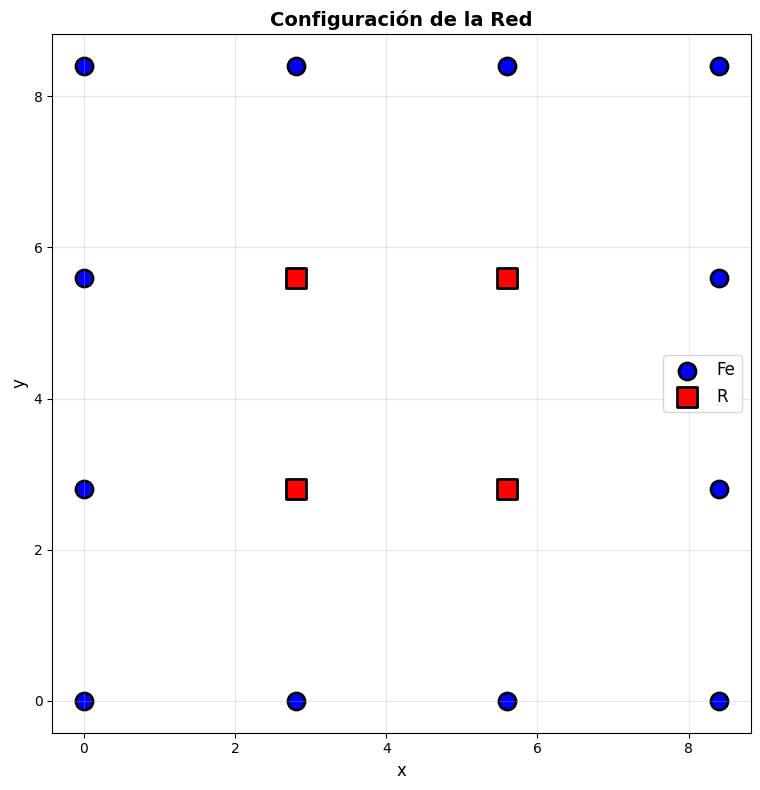

In [19]:
create_4x4_lattice().visualize()

## TAREA 1

Creamos un optimizador de fuerza bruta, lo ejecutamos, y obtenemos la mejor posición, la energía mínima, y todas las energías evaluadas. Luego establecemos el Ti en la posición óptima encontrada y visualizamos la configuración. Al final, un gráfico nos permite ver visualmente dónde está el sitio óptimo en relación con los átomos R.

Red cristalina 4x4 creada.
Total de átomos: 4
Sitios disponibles para Ti: 12


TAREA 1: BÚSQUEDA POR FUERZA BRUTA
Posición (0, 0): Energía = -9.744382
Posición (0, 1): Energía = -9.157522
Posición (0, 2): Energía = -9.157522
Posición (0, 3): Energía = -9.744382
Posición (1, 0): Energía = -9.157522
Posición (1, 3): Energía = -9.157522
Posición (2, 0): Energía = -9.157522
Posición (2, 3): Energía = -9.157522
Posición (3, 0): Energía = -9.744382
Posición (3, 1): Energía = -9.157522
Posición (3, 2): Energía = -9.157522
Posición (3, 3): Energía = -9.744382

Mejor posición encontrada: (0, 3)
Energía mínima: -9.744382


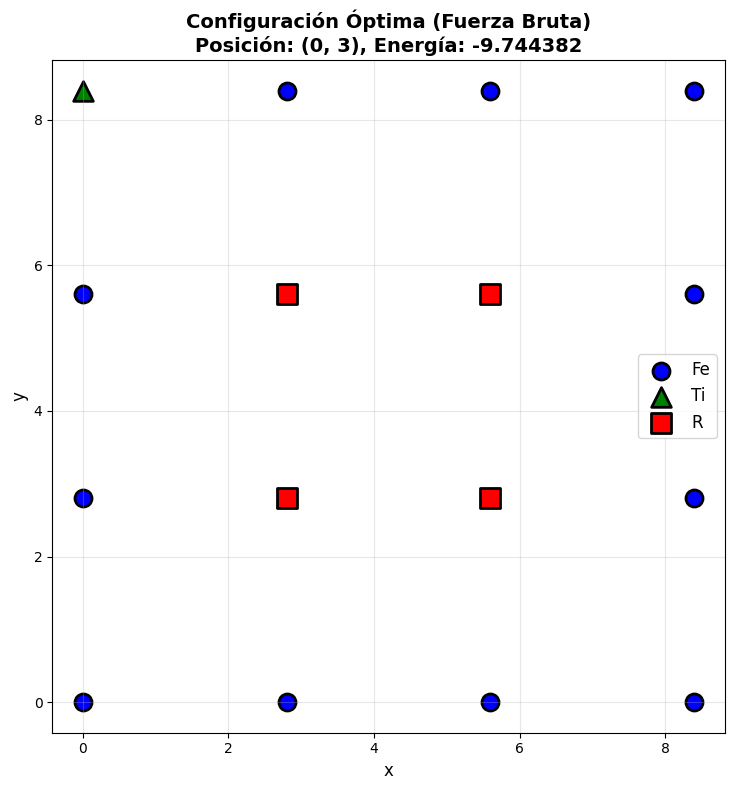

In [10]:
lattice = create_4x4_lattice()
print("Red cristalina 4x4 creada.")
print(f"Total de átomos: {len(lattice.atoms)}")
print(f"Sitios disponibles para Ti: {sum(sum(1 for a in row if not a.fixed) for row in lattice.atoms)}")
print()

print("\n" + "=" * 70)
print("TAREA 1: BÚSQUEDA POR FUERZA BRUTA")
print("=" * 70)

brute_force = BruteForceOptimizer(lattice)
best_pos_bf, best_energy_bf, all_energies = brute_force.optimize()

lattice.set_ti_position(best_pos_bf)
lattice.visualize(f"Configuración Óptima (Fuerza Bruta)\nPosición: {best_pos_bf}, Energía: {best_energy_bf:.6f}")

The following cell is temporary, DO NOT ERASE

## TAREA 2

Ejecutamos múltiples veces el SA para verificar qué tan confiablemente encuentra el óptimo global. Ejecutamos tres veces el algoritmo, y para cada ejecución creamos un nuevo optimizador con los mismos parámetros. Guardamos los resultados de cada ejecución en una lista. Solo mostramos el gráfico de convergencia para la última ejecución.


TAREA 2: RECOCIDO SIMULADO

--- Ejecución 1 de 3 ---
Temperatura inicial: 10.0000
Posición inicial: (0, 2), Energía: -9.157522

Iteración 500: T=0.7694, E_actual=-9.744382, E_mejor=-9.744382
Iteración 1000: T=0.0592, E_actual=-9.744382, E_mejor=-9.744382

Optimización completada.
Mejor posición: (0, 3)
Mejor energía: -9.744382

--- Ejecución 2 de 3 ---
Temperatura inicial: 10.0000
Posición inicial: (3, 0), Energía: -9.744382

Iteración 500: T=0.7694, E_actual=-9.157522, E_mejor=-9.744382
Iteración 1000: T=0.0592, E_actual=-9.744382, E_mejor=-9.744382

Optimización completada.
Mejor posición: (0, 3)
Mejor energía: -9.744382

--- Ejecución 3 de 3 ---
Temperatura inicial: 10.0000
Posición inicial: (3, 0), Energía: -9.744382

Iteración 500: T=0.7694, E_actual=-9.744382, E_mejor=-9.744382
Iteración 1000: T=0.0592, E_actual=-9.744382, E_mejor=-9.744382

Optimización completada.
Mejor posición: (0, 3)
Mejor energía: -9.744382


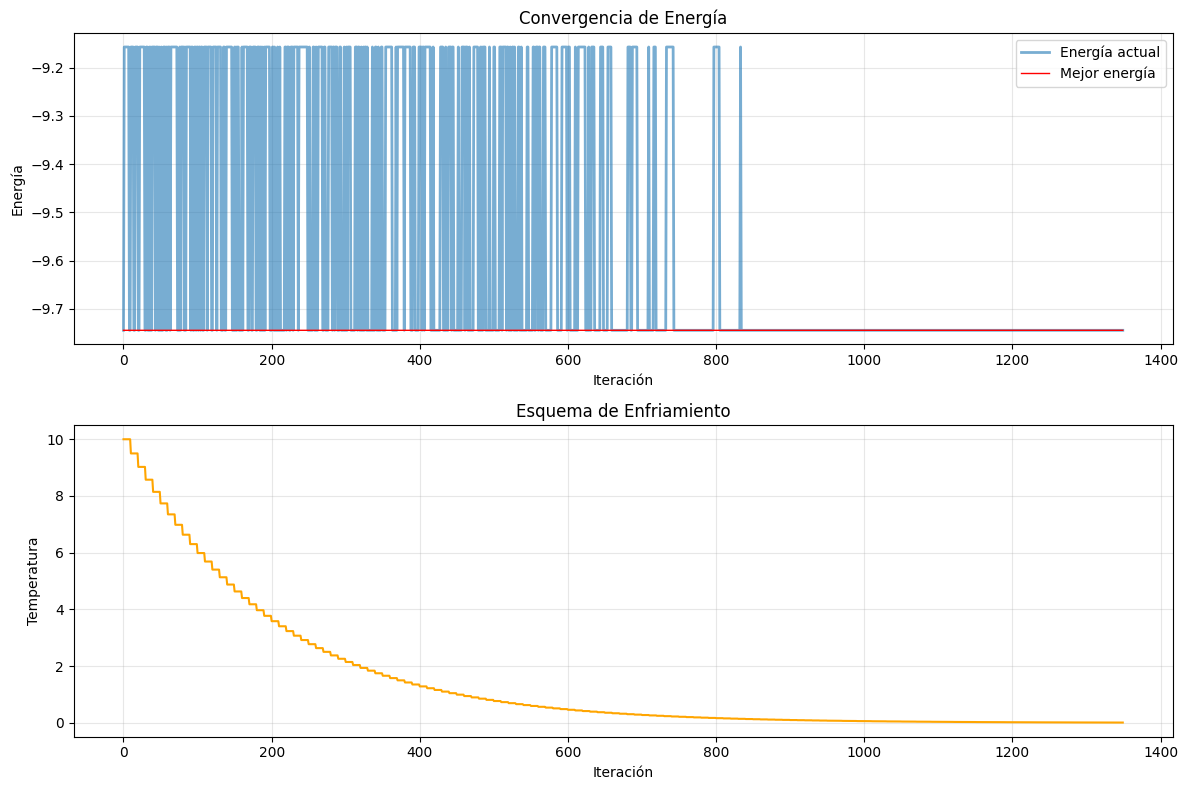


ANÁLISIS DE RESULTADOS

Fuerza Bruta:
  Mejor posición: (0, 3)
  Energía mínima: -9.744382

Recocido Simulado (3 ejecuciones):
  Ejecución 1: Posición (0, 3), Energía -9.744382 ✓
  Ejecución 2: Posición (0, 3), Energía -9.744382 ✓
  Ejecución 3: Posición (0, 3), Energía -9.744382 ✓

Tasa de éxito: 100.0%


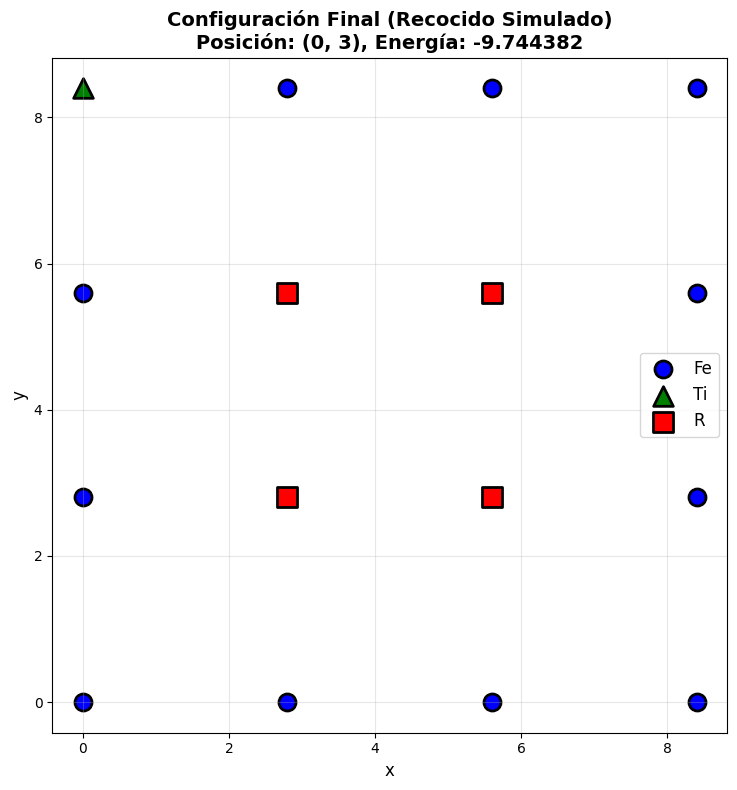

In [ ]:
print("\n" + "=" * 70)
print("TAREA 2: RECOCIDO SIMULADO")
print("=" * 70)

# Ejecutar múltiples veces para verificar consistencia
n_runs = 3
sa_results = []
lattice = create_4x4_lattice()

for run in range(n_runs):
    print(f"\n--- Ejecución {run + 1} de {n_runs} ---")

    sa_optimizer = SimulatedAnnealingOptimizer(
        lattice,
        initial_temp=10.0,
        final_temp=0.01,
        cooling_rate=0.95,
        iterations_per_temp=10
        )

    best_pos_sa, best_energy_sa = sa_optimizer.optimize()
    sa_results.append((best_pos_sa, best_energy_sa))

    #visualizar convergencia de la última ejecución
    if run == n_runs - 1:
        sa_optimizer.plot_convergence()

print("\n" + "=" * 70)
print("ANÁLISIS DE RESULTADOS")
print("=" * 70)

print(f"\nFuerza Bruta:")
print(f"  Mejor posición: {best_pos_bf}")
print(f"  Energía mínima: {best_energy_bf:.6f}")

print(f"\nRecocido Simulado ({n_runs} ejecuciones):")
for i, (pos, energy) in enumerate(sa_results, 1):
    match = "MATCH" if np.isclose(pos, best_pos_bf)[0] else "✗"
    # print("Match:", np.isclose(pos, best_pos_bf)[0])
    print(f"  Ejecución {i}: Posición {pos}, Energía {energy:.6f} {match}")

#!Determine how to set the desired precision to np.isclose
success_rate = sum(1 for pos, _ in sa_results if np.isclose(pos, best_pos_bf)[0]) / n_runs * 100
print(f"\nTasa de éxito: {success_rate:.1f}%")

lattice.set_ti_position(sa_results[-1][0])
lattice.visualize(f"Configuración Final (Recocido Simulado)\nPosición: {sa_results[-1][0]}, Energía: {sa_results[-1][1]:.6f}")

## TAREA 3

Establecemos el Ti en la posición óptima encontrada por fuerza bruta. Obtenemos el objeto átomo de Ti usando el índice guardado. Filtramos solo los átomos R de la lista completa de átomos. Para cada átomo R, calculamos la distancia al Ti, la guardamos y la imprimimos. Calculamos el promedio de todas estas distancias. Este análisis numérico nos permite responder ¿Cuál es la característica principal del sitio óptimo? y verificar la conclusión de la tesis de Skelland: "el Titanio prefiere sitios alejados de las tierras raras". Si vemos que el sitio óptimo está efectivamente lejos de los R, esto confirma la teoría física detrás del comportamiento del material.

In [23]:
print("\n" + "=" * 70)
print("TAREA 3: ANÁLISIS FÍSICO")
print("=" * 70)

lattice.set_ti_position(best_pos_bf)
ti_atom = lattice.atoms[best_pos_bf[0]][best_pos_bf[1]]

print(f"\nPosición óptima del Ti: {best_pos_bf}")
print("\nDistancias desde el Ti a los átomos R:")

r_atoms = []
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        atom = lattice.atoms[i][j]
        if atom is not None and atom.atom_type == 'R':
            r_atoms.append(atom)

distances_to_r = []

for r_atom in r_atoms:
    dist = ti_atom.distance_to(r_atom)
    distances_to_r.append(dist)
    print(f"  R en {r_atom.position}: distancia = {dist:.4f}")

avg_distance = np.mean(distances_to_r)
min_distance = np.min(distances_to_r)
max_distance = np.max(distances_to_r)

print(f"\nEstadísticas de distancias Ti-R:")
print(f"  Distancia promedio: {avg_distance:.4f}")
print(f"  Distancia mínima:   {min_distance:.4f}")
print(f"  Distancia máxima:   {max_distance:.4f}")



TAREA 3: ANÁLISIS FÍSICO

Posición óptima del Ti: (0, 3)

Distancias desde el Ti a los átomos R:
  R en (1, 1): distancia = 6.2610
  R en (1, 2): distancia = 3.9598
  R en (2, 1): distancia = 7.9196
  R en (2, 2): distancia = 6.2610

Estadísticas de distancias Ti-R:
  Distancia promedio: 6.1003
  Distancia mínima:   3.9598
  Distancia máxima:   7.9196


Conclusión: El átomo de Ti tiende a posicionarse en sitios que maximizan su distancia promedio a los átomos de tierra rara, confirmando la preferencia del Titanio por sitios alejados de R.

In [28]:
print("\n" + "=" * 70)
print("ANÁLISIS COMPARATIVO: Distancias promedio Ti-R para todas las posiciones")
print("=" * 70)

# Crear diccionario mapeando posición -> energía usando fe_sites
energies_dict = {lattice.fe_sites[i]: all_energies[i] for i in range(len(lattice.fe_sites))}

position_distances = {}
for pos in lattice.fe_sites:
    lattice.set_ti_position(pos)
    temp_ti = lattice.atoms[pos[0]][pos[1]]
    temp_distances = [temp_ti.distance_to(r_atom) for r_atom in r_atoms]
    avg_dist = np.mean(temp_distances)
    position_distances[pos] = avg_dist

sorted_positions = sorted(position_distances.items(), key=lambda x: x[1], reverse=True)

print(f"\n{'Posición':<15} {'Dist. Promedio Ti-R':<25} {'Energía':<15} {'Nota'}")
print("=" * 70)

for pos, avg_dist in sorted_positions:
    energy = energies_dict[pos]
    marker = " <- ÓPTIMA" if pos == best_pos_bf else ""
    print(f"{str(pos):<15} {avg_dist:<25.4f} {energy:<15.6f}{marker}")

lattice.set_ti_position(best_pos_bf)


ANÁLISIS COMPARATIVO: Distancias promedio Ti-R para todas las posiciones

Posición        Dist. Promedio Ti-R       Energía         Nota
(0, 3)          6.1003                    -9.744382       <- ÓPTIMA
(3, 3)          6.1003                    -9.744382      
(0, 0)          6.1003                    -9.744382      
(3, 0)          6.1003                    -9.744382      
(1, 3)          4.6552                    -9.157522      
(2, 3)          4.6552                    -9.157522      
(0, 2)          4.6552                    -9.157522      
(3, 2)          4.6552                    -9.157522      
(0, 1)          4.6552                    -9.157522      
(3, 1)          4.6552                    -9.157522      
(1, 0)          4.6552                    -9.157522      
(2, 0)          4.6552                    -9.157522      


La posición óptima también tiene la mayor distancia promedio a R, esto confirma fuertemente la hipótesis de Skelland.

# Problema 2

## `TbyTLattice`

En primer lugar, se necesita crear una red de tamaño $10 \times 10$. Para ello, se modificará la clase `CrystalLattice2D`, creando `TbyTLattice` (principalmente, para optimizar la función de energía mientras se hace el recocido y admitir varios átomos de Ti).

In [86]:
class TbyTLattice:
    """Representa una red cristalina 2D con átomos."""

    def __init__(self, morse_db: MorseParameterDatabase,
                 shape: Tuple[int, int] = (4, 4)):
        self.shape: list = shape
        self.atoms: List[List[Atom]] = [[None for _ in range(shape[1])] for _ in range(shape[0])]
        self.fe_sites: list[Tuple[int, int]] = []
        self.morse_db: MorseParameterDatabase = morse_db
        self.ti_sites: list[Tuple[int, int]] = [] # Ti atoms index

    def ti_sites_random_init(self, n_ti: int = 8) -> None:
        """
        Inicializa la red con `n_ti` átomos de Ti ubicados
        en cualquiera de los lugares de `fe_sites`
        """
        if n_ti > len(self.fe_sites):
            raise ValueError(f"There can be no more Ti sites ({n_ti}) than Fe sites ({len(self.fe_sites)})")
        if n_ti == self.fe_sites:
            self.ti_sites = self.fe_sites.copy()
            self.fe_sites = []
        else:
            while len(self.ti_sites) < n_ti:
                rand_pos: Tuple[int, int] = random.choice(self.fe_sites)
                if rand_pos not in self.ti_sites:
                    self.swap_ti_position(None, rand_pos)
                    for i, pos in enumerate(self.fe_sites):
                        if pos == rand_pos:
                            self.fe_sites.pop(i)
                            break

    def calculate_total_energy(self, prev_pos: Tuple[int, int], new_pos: Tuple[int, int], current_energy: float) -> float:
        """
        Calcula la energía total del sistema.
        Si `current_energy` es None, se calcula la energía sumando la interacción de cada pareja única de átomos una por una.
        De otro modo, se intercambian el átomo de Ti que hay en `prev_pos` (si lo había) por el que está en `new_pos` y:
        - Se revisa si `new_pos` es la misma `prev_pos`.
        - Se revisa potencial simetría del sistema al hacer el intercambio.
        - Se revisa si se van a intercambiar dos átomos de Ti.
        En cualquiera de los tres casos anteriores, se retorna `current_energy`. De otro modo, se restan todas las interacciones que los átomos en `prev_pos` y `new_pos` tenían con los demás.
        """
        if current_energy is None:
            total_energy = 0.0
            n_total_atoms = len(self.atoms) * len(self.atoms[0])
            n_row_atoms = len(self.atoms[0])

            # Calcular la sumatoria sum_{i} sum_{j>i} U_{ij}(r_{ij})
            for i in range(n_total_atoms):
                for j in range(i + 1, n_total_atoms):
                    atom_i = self.atoms[int(i / n_row_atoms)][i % n_row_atoms]
                    atom_j = self.atoms[int(j / n_row_atoms)][j % n_row_atoms]

                    distance = atom_i.distance_to(atom_j)
                    params = self.morse_db.get_parameters( # obtener alpha, r0 y D0
                        atom_i.atom_type,
                        atom_j.atom_type
                    )

                    if params: # si son atomos de Fe, R o Ti
                        energy = params.calculate_energy(distance)
                        total_energy += energy

            return total_energy
        
        else:
            #*Si son la misma posición
            if new_pos == prev_pos:
                return current_energy
            
            # #*Si hay simetría vertical
            # elif prev_pos[1] == new_pos[1]:
            #     if prev_pos[0] == abs(self.shape[0] - 1 - new_pos[0]):
            #         #*el -1 se necesita porque la lista de átomos arranca en 0 pero shape no considera esto
            #         return current_energy
            # #*Si hay simetría horizontal
            # elif prev_pos[0] == new_pos[0]:
            #     if prev_pos[1] == abs(self.shape[1] - 1 - new_pos[1]):
            #         return current_energy
            # #!Si hay simetría diagonal ? Sería solo sobre la diagonal?

            new_energy: float = current_energy
            prev_atom: Atom = self.atoms[prev_pos[0]][prev_pos[1]]
            new_atom: Atom = self.atoms[new_pos[0]][new_pos[1]]

            def recalculate_energy(current_energy: float, atom1: Atom, atom2: Atom, operation: str = "-") -> float:
                if atom1.position == atom2.position:
                    return current_energy
                new_energy: float = current_energy
                passed_through_1: bool = False
                for row in self.atoms:
                    for atom in row:
                        #     passed_through_1 = True
                        # else:
                        #     continue
                        distance_to_1: float = atom1.distance_to(atom)
                        distance_to_2: float = atom2.distance_to(atom)
                        params_1: MorseParameters = self.morse_db.get_parameters(
                            atom.atom_type,
                            atom1.atom_type
                        )
                        params_2: MorseParameters = self.morse_db.get_parameters(
                            atom.atom_type,
                            atom2.atom_type
                        )

                        if operation == "-":
                            if atom.position != atom1.position:
                                new_energy -= params_1.calculate_energy(distance_to_1)
                            if atom.position != atom2.position:
                                new_energy -= params_2.calculate_energy(distance_to_2)
                        elif operation == "+":
                            if atom.position != atom1.position:
                                new_energy += params_1.calculate_energy(distance_to_1)
                            if atom.position != atom2.position:
                                new_energy += params_2.calculate_energy(distance_to_2)


                return new_energy
            
            new_energy = recalculate_energy(new_energy, prev_atom, new_atom, "-")
            self.swap_ti_position(prev_pos, new_pos)
            new_energy = recalculate_energy(new_energy, prev_atom, new_atom, "+")

            return new_energy

    def swap_ti_position(self, prev_pos: Tuple[int, int], new_pos: Tuple[int, int]):
        """
        Si `prev_pos` y `new_pos` no son None, intercambia el tipo de átomo en dichas posiciones siempre y cuando:
        - En `prev_pos` y en `new_pos` hay un átomo movible, y en `prev_pos` hay un átomo de Ti.
        - Ambas componentes de de las posiciones son menores que la dimensión de un lado
        del retículo.
        Por otro lado, si `prev_pos` es None, añade `new_pos` a `ti_sites` si es una posición valida.
        """
        if prev_pos is None:
            if 0 <= new_pos[0] < self.shape[0] and 0 <= new_pos[1] < self.shape[1]:
                if self.atoms[new_pos[0]][new_pos[1]].fixed == False:
                    self.atoms[new_pos[0]][new_pos[1]].atom_type = "Ti"
                    self.ti_sites.append(new_pos)
        else:
            if self.atoms[prev_pos[0]][prev_pos[1]].atom_type != "Ti":
                print(f"At prev_pos there must be a Ti atom but there is a {self.atoms[prev_pos[0]][prev_pos[1]].atom_type}")

            if len(self.ti_sites) > 0:
                if self.atoms[prev_pos[0]][prev_pos[1]].fixed == False and self.atoms[new_pos[0]][new_pos[1]].fixed == False:
                    if 0<= prev_pos[0] < self.shape[0] and 0<= new_pos[0] < self.shape[0] and 0<= prev_pos[1] < self.shape[1] and 0 <= new_pos[1] < self.shape[1]:
                        if self.atoms[new_pos[0]][new_pos[1]].atom_type == "Fe":
                            self.atoms[prev_pos[0]][prev_pos[1]].atom_type = "Fe"
                            for i, pos in enumerate(self.fe_sites):
                                if pos == new_pos:
                                    self.fe_sites[i] = prev_pos
                                    break
                        self.atoms[new_pos[0]][new_pos[1]].atom_type = "Ti"
                        for i, pos in enumerate(self.ti_sites):
                            if pos == prev_pos:
                                self.ti_sites[i] = new_pos
                                break
            else:
                raise ValueError("The list of ti sites is empty; there are no Ti atoms in the lattice")

    def get_state(self) -> tuple:
        """Retorna el índice del átomo de Fe que contiene Ti"""
        if self.ti_pos is None:
            return (-1, -1)
        return self.ti_pos

    def visualize(self, title: str = "Configuración de la Red"):
        """Visualiza la red cristalina"""
        fig, ax = plt.subplots(figsize=(8, 8))

        for row in self.atoms:
            for atom in row:
                x, y = atom.position
                if atom.atom_type == 'R':
                    color = 'red'
                    marker = 's'
                    size = 200
                elif atom.atom_type == 'Fe':
                    color = 'blue'
                    marker = 'o'
                    size = 150
                else:  # Ti
                    color = 'lime'
                    marker = '^'
                    size = 200

                ax.scatter(x, y, c=color, marker=marker, s=size,
                            edgecolors="black", linewidths=2, label=atom.atom_type)


        # Remover duplicados en la leyenda
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

In [38]:
def create_nxn_lattice(n: int = 10) -> TbyTLattice:
    """
    Crea una red `n`x`n` con 16 átomos de tierras raras (R) en el centro
    del retículo (si es impar, el centro se desplaza a la izquierda
    por lo que hay 4x4 átomos de tierras raras) y n^2 - 16 sitios de
    Fe disponibles.
    """
    morse_db = MorseParameterDatabase()
    lattice = TbyTLattice(morse_db, (n, n))
    lattice.atoms = [[None for _ in range(n)] for _ in range(n)]
    lattice_center: int = int((n-1)/2)

    #*Place Fe atoms outside of the inner 4x4 square of R's
    #*judging by its position (R's coordinates must be integers
    #*in the range 3, 6)
    for x in range(n):
        for y in range(n):
            if (lattice_center-1 <= x <= lattice_center+2) and (lattice_center-1 <= y <= lattice_center+2):
                lattice.atoms[x][y] = Atom("R", (x, y), True)
            else:
                lattice.atoms[x][y] = Atom("Fe", (x, y), False)
                lattice.fe_sites.append((x, y))

    # import pdb; pdb.set_trace()

    return lattice

Initial energy: -123.91169923373454


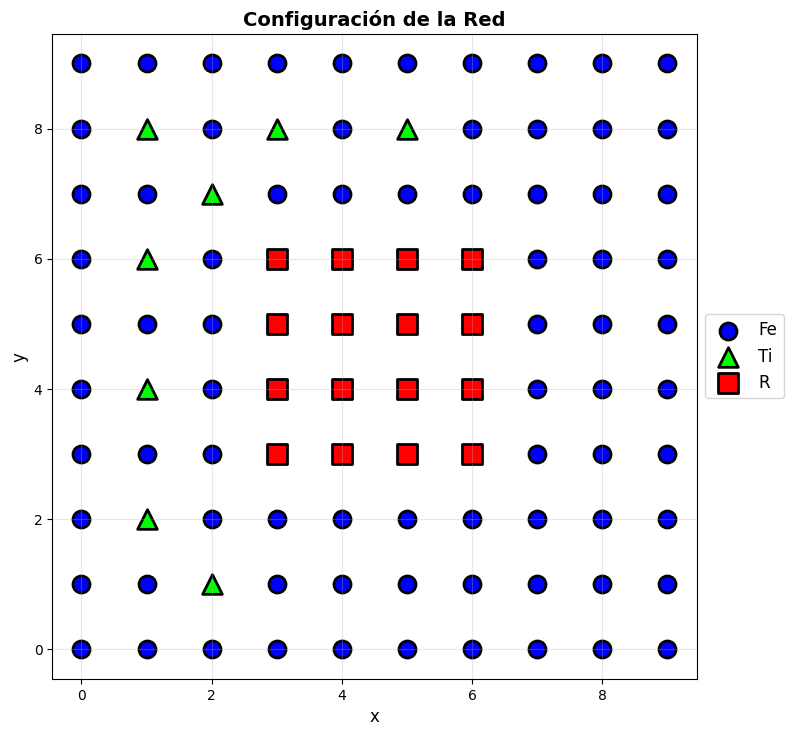

Final energy:
-122.2736833638301
With brute force: -122.27368336383023


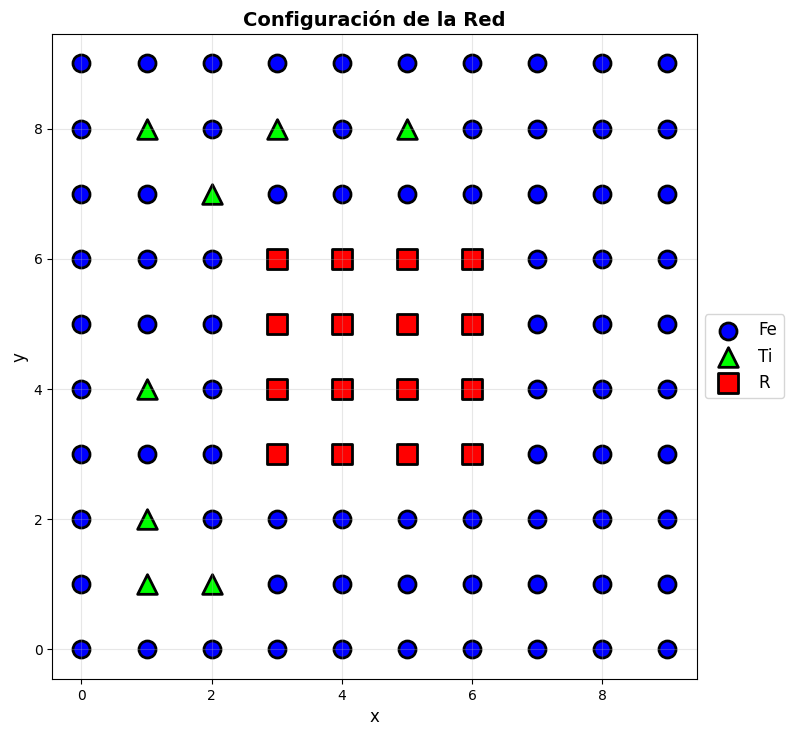

In [40]:
lattice: TbyTLattice = create_nxn_lattice(10)
ti_sites = [(1, 6), (5, 8), (2, 7), (3, 8), (2, 1), (1, 2), (1, 4), (1, 8)]
for ti in ti_sites:
    lattice.swap_ti_position(None, ti)
init_energy: float = lattice.calculate_total_energy(None, None, None)
print("Initial energy:", init_energy)
lattice.visualize()
print("Final energy:")
print(lattice.calculate_total_energy((1, 6), (1, 1), init_energy))
print("With brute force:",lattice.calculate_total_energy(None, None, None))
lattice.visualize()

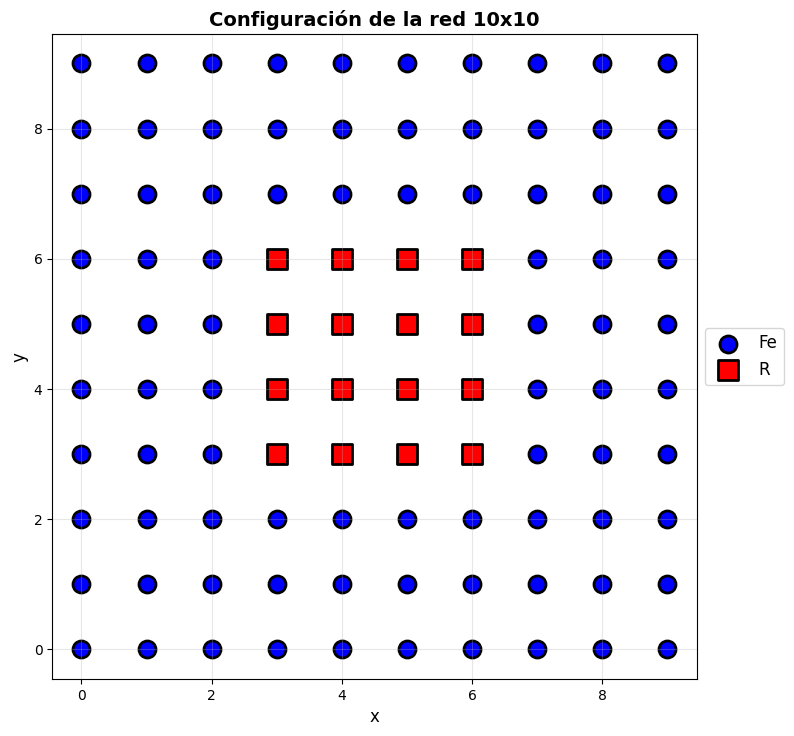

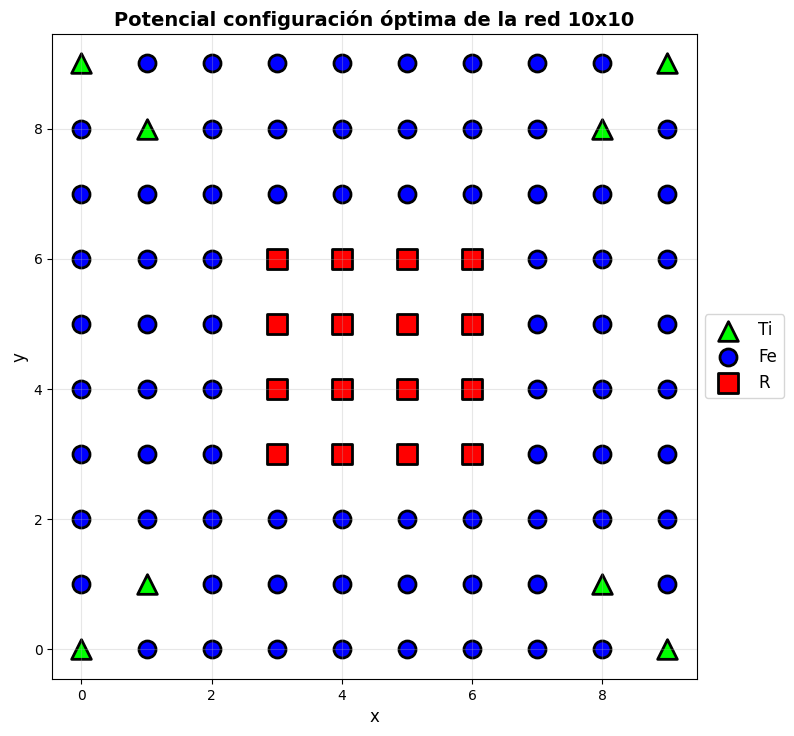

Energía: -121.74765625321186


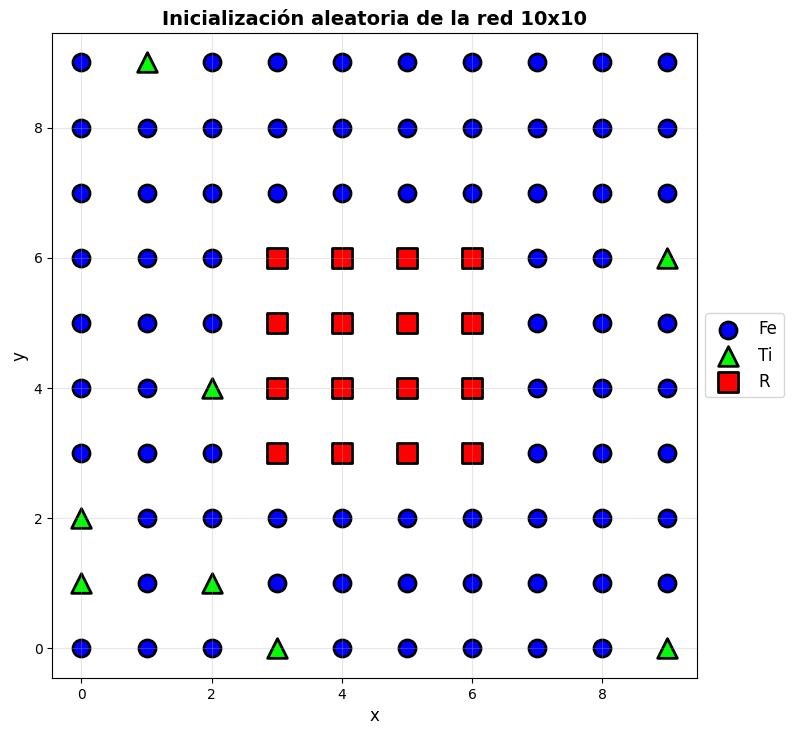

In [ ]:
lattice = create_nxn_lattice()
lattice.visualize(title="Configuración de la red 10x10")
ti_likely_pos: list[Tuple[int, int]] = [(0, 0), (1, 1), (0, 9), (1, 8), (9, 9), (8, 8), (8, 1), (9, 0)]
for pos in ti_likely_pos:
    lattice.swap_ti_position(None, pos)
lattice.visualize(f"Potencial configuración óptima de la red 10x10")
print("Energía:", lattice.calculate_total_energy(None, None, None))
lattice = create_nxn_lattice()
lattice.ti_sites_random_init()
lattice.visualize("Inicialización aleatoria de la red 10x10")

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)] 84
[(0, 0), (1, 1), (0, 9), (1, 8), (9, 9), (8, 8), (8, 1), (9, 0)] 8


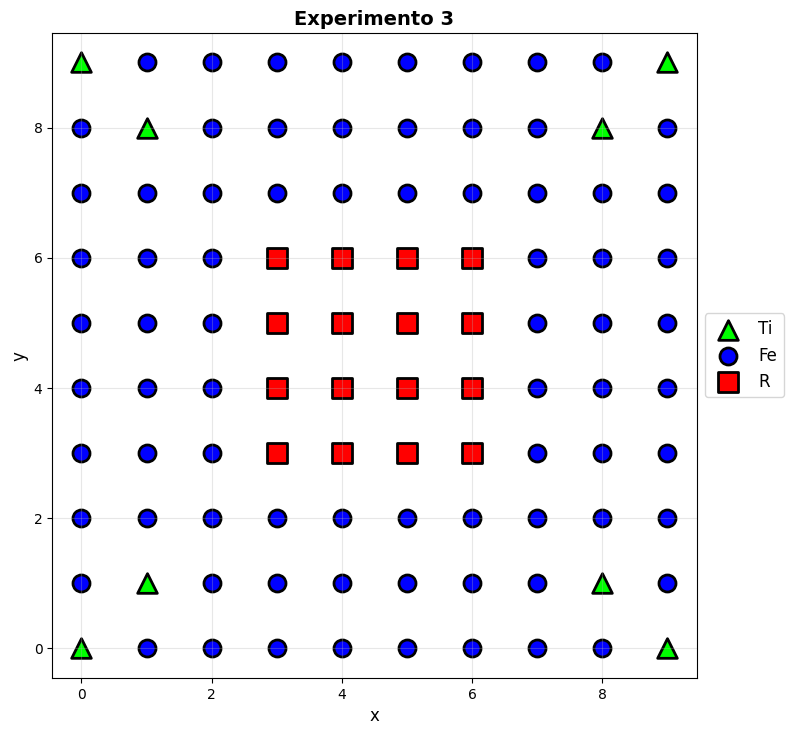

Energía de la configuración -121.74765625321


In [52]:
lattice = create_nxn_lattice()
ti_likely_pos: list[Tuple[int, int]] = [(0, 0), (1, 1), (0, 9), (1, 8), (9, 9), (8, 8), (8, 1), (9, 0)]
# ti_likely_pos: list[Tuple[int, int]] = [(3, 1), (8, 8), (6, 8), (4, 8), (8, 6), (5, 1), (1, 3), (1, 1)]
for pos in ti_likely_pos:
    lattice.swap_ti_position(None, pos)
# lattice.swap_ti_position((9, 9), (0, 2))
print(lattice.fe_sites, len(lattice.fe_sites))
print(lattice.ti_sites, len(lattice.ti_sites))
lattice.visualize(title=f'Experimento 3')
print(f'Energía de la configuración {lattice.calculate_total_energy(None, None, None):.11f}')

To be sure the method is correct, let's check it by changing any of the Ti atoms by any of the Fe atoms and checking the system's energy. Also, we check how long it takes compared to the "brute-force" method to see if it is actually worth using it.

In [ ]:
from time import perf_counter

ti_likely_pos = [(0, 0), (1, 1), (0, 9), (1, 8), (9, 9), (8, 8), (8, 1), (9, 0)]
fe_sites = [
    (r, c)
    for r in range(10)
    for c in range(10)
    if not (3 <= r <= 6 and 3 <= c <= 6)
]

optimized_times = []
brute_times = []
mismatches = []

for _ in ti_likely_pos:
    for target in fe_sites:
        if target not in ti_likely_pos:
            lattice = create_nxn_lattice()
            for pos in ti_likely_pos:
                lattice.swap_ti_position(None, pos)

            baseline_energy = lattice.calculate_total_energy(None, None, None)

            start = perf_counter()
            random_ti = random.choice(ti_likely_pos)
            optimized_energy = lattice.calculate_total_energy(random_ti, target, baseline_energy)
            optimized_times.append(perf_counter() - start)

            start = perf_counter()
            brute_force_energy = lattice.calculate_total_energy(None, None, None)
            brute_times.append(perf_counter() - start)

            if not np.isclose(optimized_energy, brute_force_energy, atol=1e-20):
                mismatches.append((random_ti, target, optimized_energy, brute_force_energy))

optimized_times = np.array(optimized_times)
brute_times = np.array(brute_times)

print(f"Checked {len(optimized_times)} swaps; mismatches: {len(mismatches)}")
print(f"Optimized mean: {optimized_times.mean():.6f}s ± {optimized_times.std():.6f}s "
      f"(min {optimized_times.min():.6f}s, max {optimized_times.max():.6f}s)")
print(f"Brute-force mean: {brute_times.mean():.6f}s ± {brute_times.std():.6f}s "
      f"(min {brute_times.min():.6f}s, max {brute_times.max():.6f}s)")

if mismatches:
    print("Example mismatch:", mismatches[0])


Checked 608 swaps; mismatches: 0
Optimized mean: 0.005073s ± 0.000777s (min 0.004369s, max 0.010486s)
Brute-force mean: 0.063965s ± 0.007356s (min 0.056803s, max 0.115862s)


## Simulated annealing

Para realizar ejecutar el algoritmo de recocido simulado, se modificará la clase `SimulatedAnnealingOptimizer` para usar `TbyTLattice`.

In [122]:
import math
from time import perf_counter

import pandas as pd

class SimulatedAnnealingTbyT:
    """
    Implementación del algoritmo de Recocido Simulado para optimización
    de la posición de átomos de Ti.
    """

    def __init__(self, lattice: TbyTLattice,
                 cooling_constant: float = 1,
                 n_cooldowns: int = 15):
        self.lattice = lattice
        # k: float = len(lattice.fe_sites) - 8 #*the number of neighbors = the number of available Fe sites
        # (k*cooling_constant / math.log(n)) +
        self.cooling_schedule: list[float] = [cooling_constant / math.log(n) for n in range(2, n_cooldowns + 2)] #*logarithmic
        # self.cooling_schedule: list[float] = [cooling_constant*(0.95**n) for n in range(2, n_cooldowns + 2)] #*exponential
        self.N_sequence: list[int] = [100 for n in range(2, n_cooldowns + 2)]
        #*Consider using exponential and then logarithmic and viceversa
        # self.N_sequence: list[int] = [2**n for n in range(2, n_cooldowns + 2)]

        #*To record progress/debugging
        self.energy_history = []
        self.temperature_history = []
        self.minimum_energy_history = []
    
    def _choose_fe_pos(self) -> Tuple[int, int]:
        """
        Chose a random position where an Fe atom is located.
        """
        return random.choice(self.lattice.fe_sites)
    
    def _acceptance_probability(self, current_energy: float,
                                new_energy: float, temperature: float) -> float:
        """
        Calculate the probability of accepting a swap (between a Ti and a Fe
        atom).
        """
        if new_energy < current_energy:
            return 1.0
        return np.exp((current_energy - new_energy) / temperature)
    
    def run(self) -> Tuple[int, float]:
        """
        Runs SA algorithm starting from a random configuration.
        """
        total_time: float = perf_counter()

        #*Initialize a random lattice and calculate its energy using the 'brute-force' approach
        self.lattice.ti_sites_random_init(n_ti=8)
        current_energy = self.lattice.calculate_total_energy(None, None, None)

        best_ti_sites = self.lattice.ti_sites
        minimum_energy = current_energy
        iteration = 0

        print("Ejecutando Recocido Simulado...")
        print(f"Temperatura inicial: {self.cooling_schedule[0]:.4f}")
        print(f"Posiciones iniciales de Ti: {self.lattice.ti_sites}, Energía: {current_energy:.6f}\n")

        for T, N in zip(self.cooling_schedule, self.N_sequence):
            print(f"Running iteration {iteration}th with temperature {T} and N {N}")
            #*Run the chain at temperature T for N steps
            for _ in range(N):
                #*Choose a random Ti atom to move, swap it with an Fe atom (inside the
                #*energy's calculation) and calculate the lattice's energy
                prev_ti_pos: Tuple[int, int] = random.choice(self.lattice.ti_sites)
                new_ti_pos = self._choose_fe_pos()
                # self.lattice.swap_ti_position(prev_ti_pos, new_ti_pos)

                new_energy = self.lattice.calculate_total_energy(prev_ti_pos, new_ti_pos, current_energy)

                #*Decide whether to accept the swap
                acceptance_prob = self._acceptance_probability(
                    current_energy, new_energy, T
                )

                if np.random.random() < acceptance_prob:
                    # current_position = new_position
                    current_energy = new_energy

                    #*If energy was minimized, update the minimum energy
                    if current_energy < minimum_energy:
                        best_ti_sites = self.lattice.ti_sites.copy()
                        minimum_energy = current_energy
                else:
                    #*If rejected, swap back the two atoms
                    #!This could be optimized by passing a  flag to the energy calculation
                    self.lattice.swap_ti_position(new_ti_pos, prev_ti_pos)

                #*Append to history
                self.energy_history.append(current_energy)
                self.temperature_history.append(T)
                self.minimum_energy_history.append(minimum_energy)

                # self.lattice.visualize()
                # brute = self.lattice.calculate_total_energy(None, None, None)
                # print(current_energy, brute, np.isclose(current_energy, brute))
            iteration += 1

            # if iteration % 500 == 0:
            #     print(f"Iteración {iteration}: T={temperature:.4f}, "
            #           f"E_actual={current_energy:.6f}, E_mejor={minimum_energy:.6f}")

        total_time = perf_counter() - total_time
        print(f"\nOptimización completada.")
        print(f"Mejor posición: {best_ti_sites}")
        print(f"Mejor energía: {minimum_energy:.6f}")

        return best_ti_sites, minimum_energy, total_time
    
    
    def plot_convergence(self, temp_shadow: bool = False, temp_gap: float = 0.1):
        """Visualiza la convergencia del algoritmo."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        iterations = range(len(self.energy_history))
        if temp_shadow:
            energy = np.asarray(self.energy_history, dtype=float)
            best = np.asarray(self.minimum_energy_history, dtype=float)
            temps = np.asarray(self.temperature_history, dtype=float)

        #*Gráfico de energía
        if temp_shadow:
            ax1.plot(iterations, energy, alpha=0.6, linewidth=2, label='Energía actual')
            ax1.plot(iterations, best, 'r-', linewidth=1, label='Mejor energía')

            #*Create mask to show shadows
            cold_mask = temps <= temp_gap
            hot_mask = temps > temp_gap
            y_min = min(energy.min(), best.min())
            y_max = max(energy.max(), best.max())

            #*Actual shadows
            ax1.fill_between(iterations, y_min, y_max, where=hot_mask,
                            color='#f48c06', alpha=0.15, step='mid',
                            label=f'T > {temp_gap:.1e}')
            ax1.fill_between(iterations, y_min, y_max, where=cold_mask,
                            color='#118ab2', alpha=0.2, step='mid',
                            label=f'T ≤ {temp_gap:.1e}')
        else:
            ax1.plot(iterations, self.energy_history, alpha=0.6,
                    linewidth=2, label='Energía actual')
        ax1.plot(iterations, self.minimum_energy_history, 'r-',
                linewidth=1, label='Mejor energía')
        ax1.set_xlabel('Iteración')
        ax1.set_ylabel('Energía')
        ax1.set_title('Convergencia de Energía')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        #*Gráfico de temperatura
        ax2.plot(iterations, self.temperature_history, 'orange')
        ax2.set_xlabel('Iteración')
        ax2.set_ylabel('Temperatura')
        ax2.set_title('Esquema de Enfriamiento')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    

In [141]:
lattice: TbyTLattice = create_nxn_lattice(10)
#*Potential constants for logarithmic scheme
# cooling_constants: list[float] = [(500 - 50*n) for n in range(5, 10)]
# cooling_constants += [25, 10, 5, 1]
# cooling_constants += [0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.001]
# cooling_constants = [0.000075, 0.000050, 0.000025, 0.000010]
cooling_constants = [0.15]

#*Potential constants for exponential scheme
# cooling_constants = [500, 250, 100, 50, 10, 1, 0.5, 0.05, 0.005]

print(len(cooling_constants), cooling_constants)
history: pd.DataFrame = pd.DataFrame(columns=['C', 'Minimum energy', 'Best Ti sites', 'Total time'])

#*Simulate for all cooling constants
for c in cooling_constants:
    print(f"############# C: {c} #############")
    for _ in range(1):
        sa_optimizer = SimulatedAnnealingTbyT(
                lattice,
                cooling_constant=c,
                n_cooldowns=200
                )
        best_ti_sites, minimum_energy, time = sa_optimizer.run()
        history = pd.concat([history, pd.DataFrame([{"C": c, 
        "Minimum energy": minimum_energy, "Best Ti sites": best_ti_sites, "Total time": time}])], ignore_index=True) #*the dict must be in a list to preserve the list of Ti sites in a single row, col position

history
# history.to_csv("P2/C_estimation.csv")
# sa_optimizer = SimulatedAnnealingTbyT(
#         lattice,
#         cooling_constant=500,
#         n_cooldowns=10
#         )
# best_ti_sites, minimum_energy, time = sa_optimizer.run()
# history = pd.concat([history, pd.DataFrame([{"Minimum energy": minimum_energy, "Best Ti sites": best_ti_sites, "Total time": time}])]) #*the dict must be in a list to preserve the list of Ti sites in a single row, col position
# history

1 [0.15]
############# C: 0.15 #############
Ejecutando Recocido Simulado...
Temperatura inicial: 0.2164
Posiciones iniciales de Ti: [(0, 5), (8, 4), (0, 8), (0, 7), (4, 8), (6, 1), (2, 2), (1, 1)], Energía: -122.029722

Running iteration 0th with temperature 0.21640425613334452 and N 100
Running iteration 1th with temperature 0.13653588399402558 and N 100
Running iteration 2th with temperature 0.10820212806667226 and N 100
Running iteration 3th with temperature 0.09320024018394177 and N 100
Running iteration 4th with temperature 0.08371659398268709 and N 100
Running iteration 5th with temperature 0.07708475135546261 and N 100
Running iteration 6th with temperature 0.07213475204444818 and N 100
Running iteration 7th with temperature 0.06826794199701279 and N 100
Running iteration 8th with temperature 0.06514417228548777 and N 100
Running iteration 9th with temperature 0.06255485871363695 and N 100
Running iteration 10th with temperature 0.0603644406572767 and N 100
Running iteration 11

/tmp/ipykernel_11840/3690431518.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame([{"C": c,


,C,Minimum energy,Best Ti sites,Total time
0,0.15,-123.911699,"[(8, 1), (1, 2), (2, 1), (8, 3), (8, 5), (4, 1...",55.293879


In [142]:
# times.sum()
print(time)

55.29387932400277


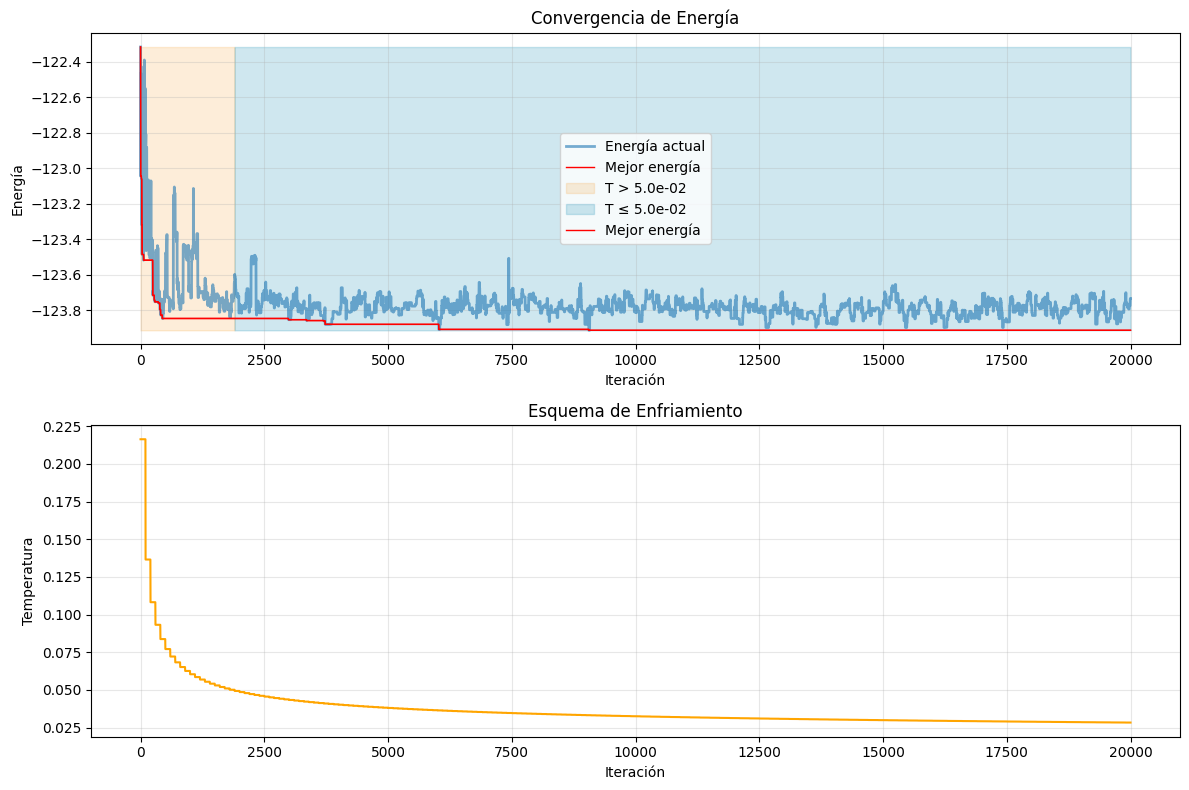

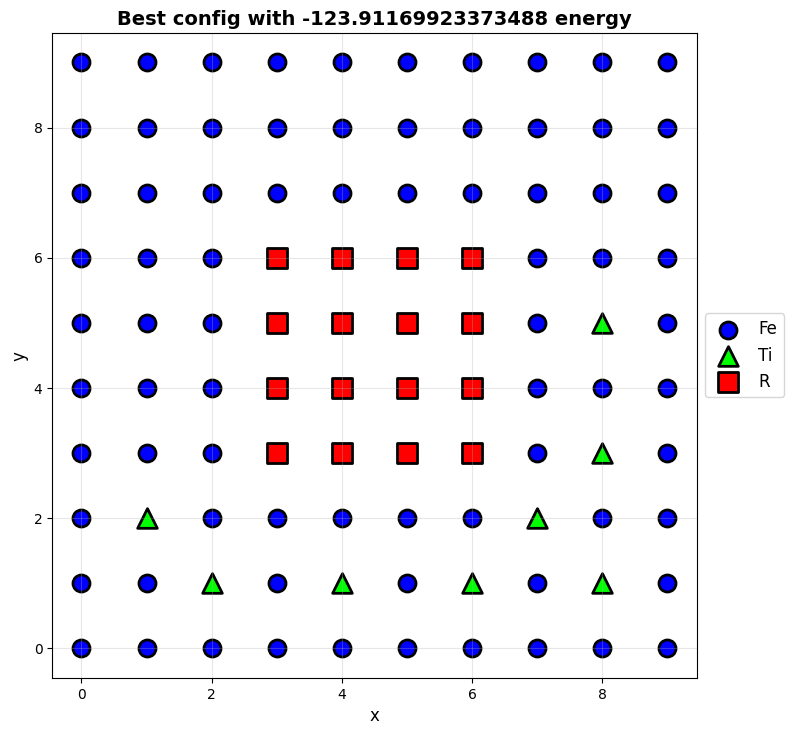

In [144]:
sa_optimizer.plot_convergence(True, 0.05)
lattice = create_nxn_lattice(10)
for ti_site in best_ti_sites:
    lattice.swap_ti_position(None, ti_site)
lattice.visualize(f"Best config with {minimum_energy} energy")

In [ ]:
# sufix_list: list[float] = ['300', '5', '0.001', '0.0001'] #*For logarithmic scheme
sufix_list: list[float] = ['exp1', 'exp2'] #*For exponential scheme
for sufix in sufix_list:
    df = pd.read_csv(f'P2/C_estimation_{sufix}.csv')
    unique_c_values: list[float] = []
    for i in range(len(df)):
        if df['C'].iloc[i] not in unique_c_values:
            unique_c_values.append(df['C'].iloc[i])
    # print(unique_c_values)

    for c in unique_c_values:
        print(r"\hline")
        print(f"{c} & {df[df['C'] == c]['Minimum energy'].mean():.11f} \\\\")
        # print(f"For C={c}, the mean energy is: {df[df['C'] == c]['Minimum energy'].mean():.11f}")

\hline
500.0 & -123.89331691916 \\
\hline
250.0 & -123.91169923374 \\
\hline
100.0 & -123.91169923373 \\
\hline
50.0 & -123.91169923373 \\
\hline
10.0 & -123.91169923374 \\
\hline
1.0 & -123.91169923373 \\
\hline
0.5 & -123.91169923374 \\
\hline
0.05 & -123.91169923374 \\
\hline
0.005 & -123.91169923373 \\
\hline
500.0 & -123.91169923373 \\
\hline
250.0 & -123.91169923373 \\
\hline
100.0 & -123.91169923373 \\
\hline
50.0 & -123.91169923373 \\
\hline
10.0 & -123.91169923373 \\
\hline
1.0 & -123.91169923373 \\
\hline
0.5 & -123.91169923373 \\
\hline
0.05 & -123.91169923373 \\
\hline
0.005 & -123.91169923374 \\


# Problema 3

Acá ya no podemos reutilizar tanto las clases pasadas puesto que se tenía como supuesto que manejábamos una red reticular por lo que obtener posiciones era más sencillo. En este caso se nos dan las coordenadas de los átomos de Fe y de Nd en una supercelda 2x2x1 por lo que calcularemos las distancias directamente con estas posiciones con la distancia euclidiana en $\mathbb{R}^3$. Primero visualicemos cómo lucen los átomos en la estructura mencionada anteriormente:

In [56]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Load both datasets
fe_data = np.loadtxt('Parcial2/Fe_positions_v2.txt')
nd_data = np.loadtxt('Parcial2/Nd_positions_v2.txt')

#Remmove duplicates if any
fe_data = np.unique(fe_data, axis=0)
nd_data = np.unique(nd_data, axis=0)
# Create interactive 3D scatter plot with both atom types
fig = go.Figure()

# Add Fe atoms (red)
fig.add_trace(go.Scatter3d(
    x=fe_data[:, 0],
    y=fe_data[:, 1],
    z=fe_data[:, 2],
    mode='markers',
    name='Fe atoms',
    marker=dict(
        size=5,
        color='blue',
        symbol='circle'
    )
))

# Add Nd atoms (blue)
fig.add_trace(go.Scatter3d(
    x=nd_data[:, 0],
    y=nd_data[:, 1],
    z=nd_data[:, 2],
    mode='markers',
    name='Nd atoms',
    marker=dict(
        size=7,  # Slightly larger for Nd
        color='red',
        symbol='circle'
    )
))

fig.update_layout(
    title='Fe and Nd Atom Positions (Interactive)',
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)',
        zaxis_title='Z (Å)',
        #aspectmode='data'  # Keep aspect ratio
    ),
    showlegend=True
)

fig.show()



In [14]:
import numpy as np

class MorseParameters:
    def __init__(self, D0, alpha, r0):
        self.D0 = D0
        self.alpha = alpha
        self.r0 = r0
    
    def calculate_energy(self, r):
        """Calculate Morse potential energy at distance r"""
        return self.D0 * (np.exp(-2*self.alpha*(r - self.r0)) - 2*np.exp(-self.alpha*(r - self.r0)))

# Morse parameters
params = {
    ('Fe', 'Fe'): MorseParameters(D0=0.764, alpha=1.5995, r0=2.7361),
    ('Fe', 'R'): MorseParameters(D0=0.6036, alpha=1.6458, r0=3.188),
    ('R', 'R'): MorseParameters(D0=0.312, alpha=0.945, r0=4.092),
}

def get_parameters(type1, type2):
    """Get Morse parameters for atom pair (order independent)"""
    if (type1, type2) in params:
        return params[(type1, type2)]
    elif (type2, type1) in params:
        return params[(type2, type1)]
    return None

# Load atomic positions
fe_data = np.loadtxt('Parcial2/Fe_positions_v2.txt')
nd_data = np.loadtxt('Parcial2/Nd_positions_v2.txt')

# Create atom list
atoms = []
for pos in fe_data:
    atoms.append(('Fe', pos))
for pos in nd_data:
    atoms.append(('R', pos))  # R for rare earth (Nd)

print(f"Total atoms: {len(atoms)}")
print(f"Fe atoms: {len(fe_data)}")
print(f"Nd atoms: {len(nd_data)}")

# Calculate total energy
total_energy = 0.0
energy_by_type = {}
count_by_type = {}

n_atoms = len(atoms)
for i in range(n_atoms):
    for j in range(i + 1, n_atoms):
        type_i, pos_i = atoms[i]
        type_j, pos_j = atoms[j]
        
        # Calculate distance
        distance = np.linalg.norm(pos_i - pos_j)
        
        # Get Morse parameters
        morse_params = get_parameters(type_i, type_j)
        
        if morse_params:
            energy = morse_params.calculate_energy(distance)
            total_energy += energy
            
            # Track by pair type
            pair_type = f"{type_i}-{type_j}" if type_i <= type_j else f"{type_j}-{type_i}"
            energy_by_type[pair_type] = energy_by_type.get(pair_type, 0) + energy
            count_by_type[pair_type] = count_by_type.get(pair_type, 0) + 1

# Print results
print(f"\nTotal pairs: {n_atoms * (n_atoms - 1) // 2}")
print(f"\nEnergy contributions by pair type:")
for pair_type in sorted(energy_by_type.keys()):
    energy = energy_by_type[pair_type]
    count = count_by_type[pair_type]
    avg = energy / count
    print(f"  {pair_type}: {energy:.2f} eV ({count} pairs, avg={avg:.4f} eV/pair)")

print(f"\n{'='*50}")
print(f"TOTAL ENERGY (Fe + Nd only): {total_energy:.2f} eV")
print(f"{'='*50}")

Total atoms: 112
Fe atoms: 96
Nd atoms: 16

Total pairs: 6216

Energy contributions by pair type:
  Fe-Fe: -203.33 eV (4560 pairs, avg=-0.0446 eV/pair)
  Fe-R: 113.46 eV (1536 pairs, avg=0.0739 eV/pair)
  R-R: 43.66 eV (120 pairs, avg=0.3638 eV/pair)

TOTAL ENERGY (Fe + Nd only): -46.21 eV


Vemos que son tres capas paralelas, donde la segunda no posee átomos de Nd.

In [15]:
class Atom:
    """Representa un átomo en la red cristalina."""

    def __init__(self, atom_type, position, fixed: bool = True):
        self.atom_type = atom_type
        self.position = position
        self.pos_arr = np.array(position, dtype=float)
        self.fixed = fixed

    def distance_to(self, other: 'Atom') -> float:
        """Calcula la distancia euclidiana a otro átomo."""
        return np.linalg.norm(self.pos_arr - other.pos_arr)

class Supercell_2x2x1:
    def __init__(self, morse_db: MorseParameterDatabase, fe_pos:str = 'Parcial2/Fe_positions_v2.txt', nd_pos:str = 'Parcial2/Nd_positions_v2.txt'):
        fe_data = np.loadtxt(fe_pos)
        nd_data = np.loadtxt(nd_pos)
        fe_data = np.unique(fe_data, axis=0)
        nd_data = np.unique(nd_data, axis=0)
        
        self.nd_sites = nd_data
        self.morse_db: MorseParameterDatabase = morse_db
        
        #Initialize 8 random Ti positions from Fe positions
        self.ti_sites = {}
        # seed = 6769
        # np.random.seed(seed)
        tit = fe_data[np.random.choice(fe_data.shape[0], size=8, replace=False)]
        self.fe_sites = {} 
        self.atoms = []
                
        for ti in tit:
            ti_atom = Atom("Ti", ti, False)
            self.ti_sites[tuple(ti)] = ti_atom
            self.atoms.append(ti_atom)
            
        for fe in fe_data: 
            if any(np.array_equal(fe, ti) for ti in tit):
                continue
            fe_atom = Atom("Fe", fe, False)
            self.fe_sites[tuple(fe)] = fe_atom
            self.atoms.append(fe_atom)
        
        for nd in nd_data:
            nd_atom = Atom("R", nd, True)
            self.atoms.append(nd_atom)
        
            
    def calculate_total_energy(self, prev_atom: Atom, new_atom: Atom, current_energy: float) -> float:
        """
        Calcula la energía total del sistema.
        Si `current_energy` es None, se calcula la energía sumando la interacción de cada pareja única de átomos una por una.
        De otro modo, se intercambian el átomo de Ti que hay en `prev_pos` (si lo había) por el que está en `new_pos` y:
        - Se revisa si `new_pos` es la misma `prev_pos`.
        - Se revisa potencial simetría del sistema al hacer el intercambio.
        - Se revisa si se van a intercambiar dos átomos de Ti.
        En cualquiera de los tres casos anteriores, se retorna `current_energy`. De otro modo, se restan todas las interacciones que los átomos en `prev_pos` y `new_pos` tenían con los demás.
        """
        if current_energy is None:
            total_energy = 0.0
            n_total_atoms = len(self.atoms)

            # Calcular la sumatoria sum_{i} sum_{j>i} U_{ij}(r_{ij})
            for i in range(n_total_atoms):
                for j in range(i + 1, n_total_atoms):
                    atom_i: Atom = self.atoms[i]
                    atom_j: Atom = self.atoms[j]

                    distance = atom_i.distance_to(atom_j)
                    params = self.morse_db.get_parameters( # obtener alpha, r0 y D0
                        atom_i.atom_type,
                        atom_j.atom_type
                    )

                    if params: # si son atomos de Fe, R o Ti
                        energy = params.calculate_energy(distance)
                        total_energy += energy

            return total_energy
        
        else:
            #*Si son la misma posición
            new_pos = new_atom.position
            prev_pos = prev_atom.position
            
            if np.array_equal(new_pos, prev_pos):
                return current_energy

            new_energy: float = current_energy

            def recalculate_energy(current_energy: float, atom1: Atom, atom2: Atom, operation: str = "-") -> float:
                if np.array_equal(atom1.position, atom2.position):
                    return current_energy
                new_energy: float = current_energy
                for atom in self.atoms:
                    distance_to_1: float = atom1.distance_to(atom)
                    distance_to_2: float = atom2.distance_to(atom)
                    params_1: MorseParameters = self.morse_db.get_parameters(
                        atom.atom_type,
                        atom1.atom_type
                    )
                    params_2: MorseParameters = self.morse_db.get_parameters(
                        atom.atom_type,
                        atom2.atom_type
                    )

                    if operation == "-":
                        if np.array_equal(atom.position, atom1.position) == False:
                            new_energy -= params_1.calculate_energy(distance_to_1)
                        if np.array_equal(atom.position, atom2.position) == False:
                            new_energy -= params_2.calculate_energy(distance_to_2)
                    elif operation == "+":
                        if np.array_equal(atom.position, atom1.position) == False:
                            new_energy += params_1.calculate_energy(distance_to_1)
                        if np.array_equal(atom.position, atom2.position) == False:
                            new_energy += params_2.calculate_energy(distance_to_2)

                return new_energy
            
            new_energy = recalculate_energy(new_energy, prev_atom, new_atom, "-")
            self.swap_ti_position(prev_atom, new_atom)
            new_energy = recalculate_energy(new_energy, prev_atom, new_atom, "+")

            return new_energy

    def swap_ti_position(self, prev_atom: Atom, new_atom: Atom):
        """
        Si `prev_atom` y `new_atom` no son None, intercambia el tipo de átomo en dichas posiciones siempre y cuando:
        - En `prev_atom` y en `new_atom` hay un átomo movible, y en `prev_atom` hay un átomo de Ti.
        - Ambas componentes de de las posiciones son menores que la dimensión de un lado
        del retículo.
        Por otro lado, si `prev_atom` es None, añade `new_atom.position` a `ti_sites` si es una posición valida.
        """
        
        if prev_atom is None:
            pass
        
        elif prev_atom.atom_type != "Ti":
            print(f"At prev_pos there must be a Ti atom but there is a {prev_atom.atom_type}")
            
        else:
            # print("Swapping atoms:" , prev_atom.position if prev_atom else None, prev_atom.atom_type if prev_atom else None, new_atom.position if new_atom else None, new_atom.atom_type if new_atom else None)
            # print("Ti sites before swap: ", self.ti_sites)
            # print("Fe sites before swap: ", self.fe_sites)
            
            del self.ti_sites[tuple(prev_atom.position)]
            del self.fe_sites[tuple(new_atom.position)]
            prev_atom.atom_type = "Fe"
            new_atom.atom_type = "Ti"
            self.ti_sites[tuple(new_atom.position)] = new_atom
            self.fe_sites[tuple(prev_atom.position)] = prev_atom
            
        
            
            # print("Ti sites after swap: ", self.ti_sites)
            # print("Fe sites after swap: ", self.fe_sites)
            # print("Now prev atom (ti) is:", prev_atom.atom_type, "and (fe)", new_atom.atom_type)
        
    def graph(self):
        fig = go.Figure()
        
        fe_data = np.array(list(self.fe_sites.keys()))
        nd_data = self.nd_sites
        ti_data = np.array(list(self.ti_sites.keys()))


        # Add Fe atoms (red)
        fig.add_trace(go.Scatter3d(
            x=fe_data[:, 0],
            y=fe_data[:, 1],
            z=fe_data[:, 2],
            mode='markers',
            name='Fe atoms',
            marker=dict(
                size=5,
                color='blue',
                symbol='circle'
            )
        ))

        # Add Nd atoms (blue)
        fig.add_trace(go.Scatter3d(
            x=nd_data[:, 0],
            y=nd_data[:, 1],
            z=nd_data[:, 2],
            mode='markers',
            name='Nd atoms',
            marker=dict(
                size=7,  # Slightly larger for Nd
                color='red',
                symbol='circle'
            )
        ))
        
        # Add Ti atoms (lime)
        fig.add_trace(go.Scatter3d(
            x=ti_data[:, 0],
            y=ti_data[:, 1],
            z=ti_data[:, 2],
            mode='markers',
            name='Ti atoms',
            marker=dict(
                size=5,
                color='lime',
                symbol='circle'
            )
        ))

        fig.update_layout(
            title='Fe, Nd, Ti Atom Positions',
            scene=dict(
                xaxis_title='X (Å)',
                yaxis_title='Y (Å)',
                zaxis_title='Z (Å)',
                #aspectmode='data'  # Keep aspect ratio
            ),
            showlegend=True
        )

        fig.show()

In [16]:
s = Supercell_2x2x1(MorseParameterDatabase())
s.graph()
print(s.calculate_total_energy(None, None, None))
#print(s.calculate_total_energy_debug(None, None, None))
#s.swap_ti_position(s.atoms[0], s.atoms[8])
print(s.calculate_total_energy(s.atoms[0], s.atoms[8], s.calculate_total_energy(None, None, None)))
s.graph()

-33.41044410442353
-33.311873521552066


Una vez tenemos la estructura ya adaptada para trabajar con coordenadas 3D, procedemos a implementar el recocido simulado.

In [20]:
import math

from time import perf_counter

class SimulatedAnnealingSupercell_2x2x1:
    """
    Implementación del algoritmo de Recocido Simulado para optimización
    de la posición de átomos de Ti.
    """

    def __init__(self, supercell: Supercell_2x2x1,
                 cooling_constant: float = 1,
                 n_cooldowns: int = 15):
        self.supercell = supercell
        k: float = len(supercell.fe_sites) #*the number of neighbors = the number of available Fe sites
        self.cooling_schedule: list[float] = [k*cooling_constant*(0.95**n)  for n in range(2, n_cooldowns + 2)]
        self.N_sequence: list[int] = [100 for n in range(2, n_cooldowns + 2)]

        #*To record progress/debugging
        self.energy_history = []
        self.temperature_history = []
        self.minimum_energy_history = []
    
    def _choose_fe_pos(self):
        """
        Chose a random position where an Fe atom is located.
        """
        fe_atom =  random.choice(list(self.supercell.fe_sites.keys()))
        print("Chosen Fe position: ", fe_atom.position)
        return fe_atom
    
    def _acceptance_probability(self, current_energy: float,
                                new_energy: float, temperature: float) -> float:
        """
        Calculate the probability of accepting a swap (between a Ti and a Fe
        atom).
        """
        if new_energy < current_energy:
            return 1.0
        return np.exp((current_energy - new_energy) / temperature)
    
    def run(self) -> Tuple[int, float]:
        """
        Runs SA algorithm starting from a random configuration.
        """
        #*Initialize a random lattice and calculate its energy using the 'brute-force' approach
        current_energy = self.supercell.calculate_total_energy(None, None, None)
        initial = current_energy
    
        best_ti_sites = self.supercell.ti_sites
        minimum_energy = current_energy
        temperature = 0
        iteration = 0

        print("Ejecutando Recocido Simulado...")
        print(f"Temperatura inicial: {temperature:.4f}")
        print(f"Posiciones iniciales de Ti: {list(self.supercell.ti_sites.keys())}, Energía: {current_energy:.6f}\n")

        for T, N in zip(self.cooling_schedule, self.N_sequence):
            print(f"Running iteration {iteration}th with temperature {T} and N {N}")
            #*Run the chain at temperature T for N steps
            for _ in range(N):
                #*Choose a random Ti atom to move, swap it with an Fe atom (inside the
                #*energy's calculation) and calculate the lattice's energy
                prev_ti: Atom= random.choice(list(self.supercell.ti_sites.values()))
                new_ti: Atom = random.choice(list(self.supercell.fe_sites.values()))
                # self.supercell.swap_ti_position(prev_ti_pos, new_ti_pos)

                # start1 = perf_counter()
                new_energy = self.supercell.calculate_total_energy(prev_ti, new_ti, current_energy)
                # energy_time = start1 - perf_counter()

                #*Decide whether to accept the swap
                # start2 = perf_counter()
                acceptance_prob = self._acceptance_probability(
                    current_energy, new_energy, T
                )
                if np.random.random() < acceptance_prob:
                    # current_position = new_position
                    current_energy = new_energy

                    #*If energy was minimized, update the minimum energy
                    if current_energy < minimum_energy:
                        best_ti_sites = self.supercell.ti_sites
                        minimum_energy = current_energy
                else:
                    #*If rejected, swap back the two atoms
                    #!This could be optimized by passing a  flag to the energy calculation
                    self.supercell.swap_ti_position(new_ti, prev_ti)

                #*Append to history
                self.energy_history.append(current_energy)
                self.temperature_history.append(T)
                self.minimum_energy_history.append(minimum_energy)
            iteration += 1

            # if iteration % 500 == 0:
            #     print(f"Iteración {iteration}: T={temperature:.4f}, "
            #           f"E_actual={current_energy:.6f}, E_mejor={minimum_energy:.6f}")

        print(f"\nOptimización completada.")
        print(f"Mejor posición: {list(best_ti_sites.keys())}")
        print(f"Mejor energía: {minimum_energy:.6f}")

        print("Diferencia de energía: ", initial - minimum_energy)
        
        
        return best_ti_sites, minimum_energy
    
    
    def plot_convergence(self):
        """Visualiza la convergencia del algoritmo."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        iterations = range(len(self.energy_history))

        # Gráfico de energía
        ax1.plot(iterations, self.energy_history, alpha=0.6,
                 linewidth=2, label='Energía actual')
        ax1.plot(iterations, self.minimum_energy_history, 'r-',
                linewidth=1, label='Mejor energía')
        ax1.set_xlabel('Iteración')
        ax1.set_ylabel('Energía')
        ax1.set_title('Convergencia de Energía')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Gráfico de temperatura
        ax2.plot(iterations, self.temperature_history, 'orange')
        ax2.set_xlabel('Iteración')
        ax2.set_ylabel('Temperatura')
        ax2.set_title('Esquema de Enfriamiento')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [21]:
supercell: Supercell_2x2x1 = Supercell_2x2x1(MorseParameterDatabase())

for c in [10, 100, 250]:
        sa_optimizer = SimulatedAnnealingSupercell_2x2x1(
                supercell,
                cooling_constant=c,
                n_cooldowns=1000
                )
        best_ti_sites, minimum_energy = sa_optimizer.run()
#supercell.graph()

Ejecutando Recocido Simulado...
Temperatura inicial: 0.0000
Posiciones iniciales de Ti: [(8.676605, 0.233685, 7.638947), (10.851695, 8.164268, 0.885078), (0.096452, 3.752499, 3.306831), (2.505694, 8.428964, 3.074532), (4.617175, 11.76963, 9.691877), (2.988473, 5.809583, 6.796071), (3.115584, 3.576601, 9.108309), (11.950787, 8.617264, 6.042968)], Energía: -39.790173

Running iteration 0th with temperature 794.1999999999999 and N 100
Running iteration 1th with temperature 754.4899999999999 and N 100
Running iteration 2th with temperature 716.7654999999999 and N 100
Running iteration 3th with temperature 680.9272249999998 and N 100
Running iteration 4th with temperature 646.8808637499998 and N 100
Running iteration 5th with temperature 614.5368205624998 and N 100
Running iteration 6th with temperature 583.8099795343747 and N 100
Running iteration 7th with temperature 554.619480557656 and N 100
Running iteration 8th with temperature 526.8885065297733 and N 100
Running iteration 9th with te

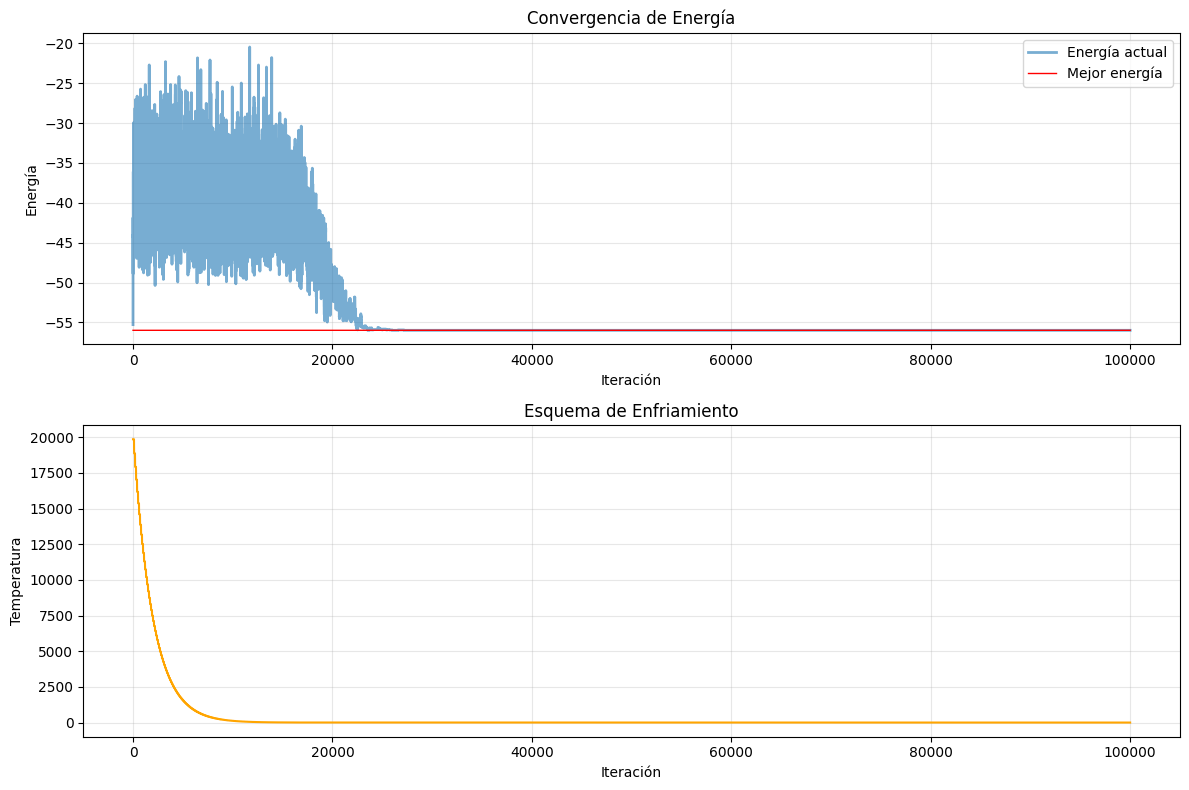

In [23]:
supercell.graph()
sa_optimizer.plot_convergence()

### Análisis Cuantitativo:

In [25]:
# Compute the average distance between Ti and the closest Nd atoms
distances = []
for ti_site in best_ti_sites.values():
    mind = np.inf
    for nd_site in supercell.nd_sites:
        dist = np.linalg.norm(ti_site.pos_arr - nd_site)
        if dist <= mind:
            mind = dist
    distances.append(mind)
average_distance = np.mean(distances)
print(distances)
print(f"Average distance between Ti and closest Nd atoms: {average_distance:.4f} Å")

# Compute the average distance between Ti and the closest Ti atoms
distances = []
for ti_site in best_ti_sites.values():
    mind = np.inf
    for other_ti_site in best_ti_sites.values():
        if not np.array_equal(ti_site.pos_arr, other_ti_site.pos_arr):
            dist = np.linalg.norm(ti_site.pos_arr - other_ti_site.pos_arr)
            if dist <= mind:
                mind = dist
    distances.append(mind)
average_distance = np.mean(distances)
print(distances)
print(f"Average distance between Ti and closest Ti atoms: {average_distance:.4f} Å")

# Compute the average distance between Ti and the closest Fe atoms
distances = []
for ti_site in best_ti_sites.values():
    mind = np.inf
    for fe_site in supercell.fe_sites.values():
        dist = np.linalg.norm(ti_site.pos_arr - fe_site.pos_arr)
        if dist <= mind:
            mind = dist
    distances.append(mind)
average_distance = np.mean(distances)
print(distances)
print(f"Average distance between Ti and closest Fe atoms: {average_distance:.4f} Å")

[4.095597040692969, 5.119168825453112, 3.7781823139194857, 3.9531345237096343, 5.155586841552182, 5.014007248661195, 3.7657121750476357, 3.175215427795412]
Average distance between Ti and closest Nd atoms: 4.2571 Å
[5.87140419033982, 5.4784367073613245, 3.373859654666299, 5.59791981933191, 5.4784367073613245, 3.373859654666299, 5.215110797858661, 6.067697369891894]
Average distance between Ti and closest Ti atoms: 5.0571 Å
[2.7801862911857196, 2.5627622974876156, 2.9370588307022385, 2.402379186061392, 2.6377064481590815, 2.3661603934680757, 2.5540949204477505, 2.6394551788797247]
Average distance between Ti and closest Fe atoms: 2.6100 Å


In [39]:
class Supercell_2x2x1:
    def __init__(self, morse_db: MorseParameterDatabase, fe_pos:str = 'Parcial2/Fe_positions_v2.txt', nd_pos:str = 'Parcial2/Nd_positions_v2.txt'):
        fe_data = np.loadtxt(fe_pos)
        nd_data = np.loadtxt(nd_pos)
        fe_data = np.unique(fe_data, axis=0)
        nd_data = np.unique(nd_data, axis=0)
        
        self.nd_sites = nd_data
        self.morse_db: MorseParameterDatabase = morse_db
        
        #Initialize 8 random Ti positions from Fe positions
        self.ti_sites = {}
        # seed = 6769
        # np.random.seed(seed)
        tit = [(0.407372, 11.569006, 0.136591), (11.825413, 10.991988, 2.999415), (0.357578, 0.843476, 0.874817), (11.827459, 2.261272, 0.287344), (0.012339, 0.18624, 9.561188), (4.617175 ,11.76963, 9.691877), (10.570495, 11.986366, 9.001430), (10.021202, 1.627433, 9.324877)]
        self.fe_sites = {} 
        self.atoms = []
                
        for ti in tit:
            ti_atom = Atom("Ti", ti, False)
            self.ti_sites[tuple(ti)] = ti_atom
            self.atoms.append(ti_atom)
            
        for fe in fe_data: 
            if any(np.array_equal(tuple(fe), ti) for ti in tit):
                print("lol")
                continue
            fe_atom = Atom("Fe", fe, False)
            self.fe_sites[tuple(fe)] = fe_atom
            self.atoms.append(fe_atom)
        
        for nd in nd_data:
            nd_atom = Atom("R", nd, True)
            self.atoms.append(nd_atom)
        
            
    def calculate_total_energy(self, prev_atom: Atom, new_atom: Atom, current_energy: float) -> float:
        """
        Calcula la energía total del sistema.
        Si `current_energy` es None, se calcula la energía sumando la interacción de cada pareja única de átomos una por una.
        De otro modo, se intercambian el átomo de Ti que hay en `prev_pos` (si lo había) por el que está en `new_pos` y:
        - Se revisa si `new_pos` es la misma `prev_pos`.
        - Se revisa potencial simetría del sistema al hacer el intercambio.
        - Se revisa si se van a intercambiar dos átomos de Ti.
        En cualquiera de los tres casos anteriores, se retorna `current_energy`. De otro modo, se restan todas las interacciones que los átomos en `prev_pos` y `new_pos` tenían con los demás.
        """
        if current_energy is None:
            total_energy = 0.0
            n_total_atoms = len(self.atoms)

            # Calcular la sumatoria sum_{i} sum_{j>i} U_{ij}(r_{ij})
            for i in range(n_total_atoms):
                for j in range(i + 1, n_total_atoms):
                    atom_i: Atom = self.atoms[i]
                    atom_j: Atom = self.atoms[j]

                    distance = atom_i.distance_to(atom_j)
                    params = self.morse_db.get_parameters( # obtener alpha, r0 y D0
                        atom_i.atom_type,
                        atom_j.atom_type
                    )

                    if params: # si son atomos de Fe, R o Ti
                        energy = params.calculate_energy(distance)
                        total_energy += energy

            return total_energy
        
        else:
            #*Si son la misma posición
            new_pos = new_atom.position
            prev_pos = prev_atom.position
            
            if np.array_equal(new_pos, prev_pos):
                return current_energy

            new_energy: float = current_energy

            def recalculate_energy(current_energy: float, atom1: Atom, atom2: Atom, operation: str = "-") -> float:
                if np.array_equal(atom1.position, atom2.position):
                    return current_energy
                new_energy: float = current_energy
                for atom in self.atoms:
                    distance_to_1: float = atom1.distance_to(atom)
                    distance_to_2: float = atom2.distance_to(atom)
                    params_1: MorseParameters = self.morse_db.get_parameters(
                        atom.atom_type,
                        atom1.atom_type
                    )
                    params_2: MorseParameters = self.morse_db.get_parameters(
                        atom.atom_type,
                        atom2.atom_type
                    )

                    if operation == "-":
                        if np.array_equal(atom.position, atom1.position) == False:
                            new_energy -= params_1.calculate_energy(distance_to_1)
                        if np.array_equal(atom.position, atom2.position) == False:
                            new_energy -= params_2.calculate_energy(distance_to_2)
                    elif operation == "+":
                        if np.array_equal(atom.position, atom1.position) == False:
                            new_energy += params_1.calculate_energy(distance_to_1)
                        if np.array_equal(atom.position, atom2.position) == False:
                            new_energy += params_2.calculate_energy(distance_to_2)

                return new_energy
            
            new_energy = recalculate_energy(new_energy, prev_atom, new_atom, "-")
            self.swap_ti_position(prev_atom, new_atom)
            new_energy = recalculate_energy(new_energy, prev_atom, new_atom, "+")

            return new_energy

    def swap_ti_position(self, prev_atom: Atom, new_atom: Atom):
        """
        Si `prev_atom` y `new_atom` no son None, intercambia el tipo de átomo en dichas posiciones siempre y cuando:
        - En `prev_atom` y en `new_atom` hay un átomo movible, y en `prev_atom` hay un átomo de Ti.
        - Ambas componentes de de las posiciones son menores que la dimensión de un lado
        del retículo.
        Por otro lado, si `prev_atom` es None, añade `new_atom.position` a `ti_sites` si es una posición valida.
        """
        
        if prev_atom is None:
            pass
        
        elif prev_atom.atom_type != "Ti":
            print(f"At prev_pos there must be a Ti atom but there is a {prev_atom.atom_type}")
            
        else:
            # print("Swapping atoms:" , prev_atom.position if prev_atom else None, prev_atom.atom_type if prev_atom else None, new_atom.position if new_atom else None, new_atom.atom_type if new_atom else None)
            # print("Ti sites before swap: ", self.ti_sites)
            # print("Fe sites before swap: ", self.fe_sites)
            
            del self.ti_sites[tuple(prev_atom.position)]
            del self.fe_sites[tuple(new_atom.position)]
            prev_atom.atom_type = "Fe"
            new_atom.atom_type = "Ti"
            self.ti_sites[tuple(new_atom.position)] = new_atom
            self.fe_sites[tuple(prev_atom.position)] = prev_atom
            
        
            
            # print("Ti sites after swap: ", self.ti_sites)
            # print("Fe sites after swap: ", self.fe_sites)
            # print("Now prev atom (ti) is:", prev_atom.atom_type, "and (fe)", new_atom.atom_type)
        
    def graph(self):
        fig = go.Figure()
        
        fe_data = np.array(list(self.fe_sites.keys()))
        nd_data = self.nd_sites
        ti_data = np.array(list(self.ti_sites.keys()))


        # Add Fe atoms (red)
        fig.add_trace(go.Scatter3d(
            x=fe_data[:, 0],
            y=fe_data[:, 1],
            z=fe_data[:, 2],
            mode='markers',
            name='Fe atoms',
            marker=dict(
                size=5,
                color='blue',
                symbol='circle'
            )
        ))

        # Add Nd atoms (blue)
        fig.add_trace(go.Scatter3d(
            x=nd_data[:, 0],
            y=nd_data[:, 1],
            z=nd_data[:, 2],
            mode='markers',
            name='Nd atoms',
            marker=dict(
                size=7,  # Slightly larger for Nd
                color='red',
                symbol='circle'
            )
        ))
        
        # Add Ti atoms (lime)
        fig.add_trace(go.Scatter3d(
            x=ti_data[:, 0],
            y=ti_data[:, 1],
            z=ti_data[:, 2],
            mode='markers',
            name='Ti atoms',
            marker=dict(
                size=5,
                color='lime',
                symbol='circle'
            )
        ))

        fig.update_layout(
            title='Fe, Nd, Ti Atom Positions',
            scene=dict(
                xaxis_title='X (Å)',
                yaxis_title='Y (Å)',
                zaxis_title='Z (Å)',
                #aspectmode='data'  # Keep aspect ratio
            ),
            showlegend=True
        )

        fig.show()

In [40]:
s = Supercell_2x2x1(MorseParameterDatabase())
s.graph()
s.calculate_total_energy(None, None, None)

lol
lol
lol
lol
lol
lol
lol
lol


-44.70385074200535